# Demonstration of metaweb embedding using RDPG

In [118]:
using EcologicalNetworks
using CairoMakie
using LinearAlgebra
import CSV
using DataFrames
using DataFramesMeta
CairoMakie.activate!(; px_per_unit = 2)

The first step is to load a series of bipartite quantitative networks between hosts and parasites, coming from the Hadfield et al. paper on host-parasite phylogenetic structure.

In [119]:
ids = getfield.(filter(n -> contains("Hadfield")(n.Reference), web_of_life()), :ID)

51-element Vector{SubString{String}}:
 "A_HP_001"
 "A_HP_002"
 "A_HP_003"
 "A_HP_004"
 "A_HP_005"
 "A_HP_006"
 "A_HP_007"
 "A_HP_008"
 "A_HP_009"
 "A_HP_010"
 ⋮
 "A_HP_043"
 "A_HP_044"
 "A_HP_045"
 "A_HP_046"
 "A_HP_047"
 "A_HP_048"
 "A_HP_049"
 "A_HP_050"
 "A_HP_051"

We convert these networks to binary bipartite networks, in order to make the metaweb aggregation easier.

In [120]:
N = [convert(BipartiteNetwork, web_of_life(n)) for n in ids]

51-element Vector{BipartiteNetwork{Bool, String}}:
 18×10 (String) bipartite ecological network (L: 61 - Bool)
 24×18 (String) bipartite ecological network (L: 96 - Bool)
 9×23 (String) bipartite ecological network (L: 108 - Bool)
 21×6 (String) bipartite ecological network (L: 52 - Bool)
 13×7 (String) bipartite ecological network (L: 51 - Bool)
 37×16 (String) bipartite ecological network (L: 123 - Bool)
 17×8 (String) bipartite ecological network (L: 43 - Bool)
 24×8 (String) bipartite ecological network (L: 37 - Bool)
 22×14 (String) bipartite ecological network (L: 97 - Bool)
 31×18 (String) bipartite ecological network (L: 88 - Bool)
 ⋮
 29×9 (String) bipartite ecological network (L: 73 - Bool)
 26×27 (String) bipartite ecological network (L: 197 - Bool)
 16×7 (String) bipartite ecological network (L: 57 - Bool)
 39×17 (String) bipartite ecological network (L: 202 - Bool)
 26×11 (String) bipartite ecological network (L: 100 - Bool)
 14×12 (String) bipartite ecological network (L:

Transforming the array of networks into a metaweb is done through the union operation:

In [121]:
M = reduce(∪, N)

206×121 (String) bipartite ecological network (L: 2131 - Bool)

In order to identify the pairs of species that have never been observed together, we use the following loop to create a co-occurence matrix:

In [122]:
C = zeros(Int64, size(M))
for n in N
    i = indexin(species(n; dims = 1), species(M; dims = 1))
    j = indexin(species(n; dims = 2), species(M; dims = 2))
    C[i, j] .+= 1
end

Before moving forward with the results, we will setup the multi-panel figure used in main text:

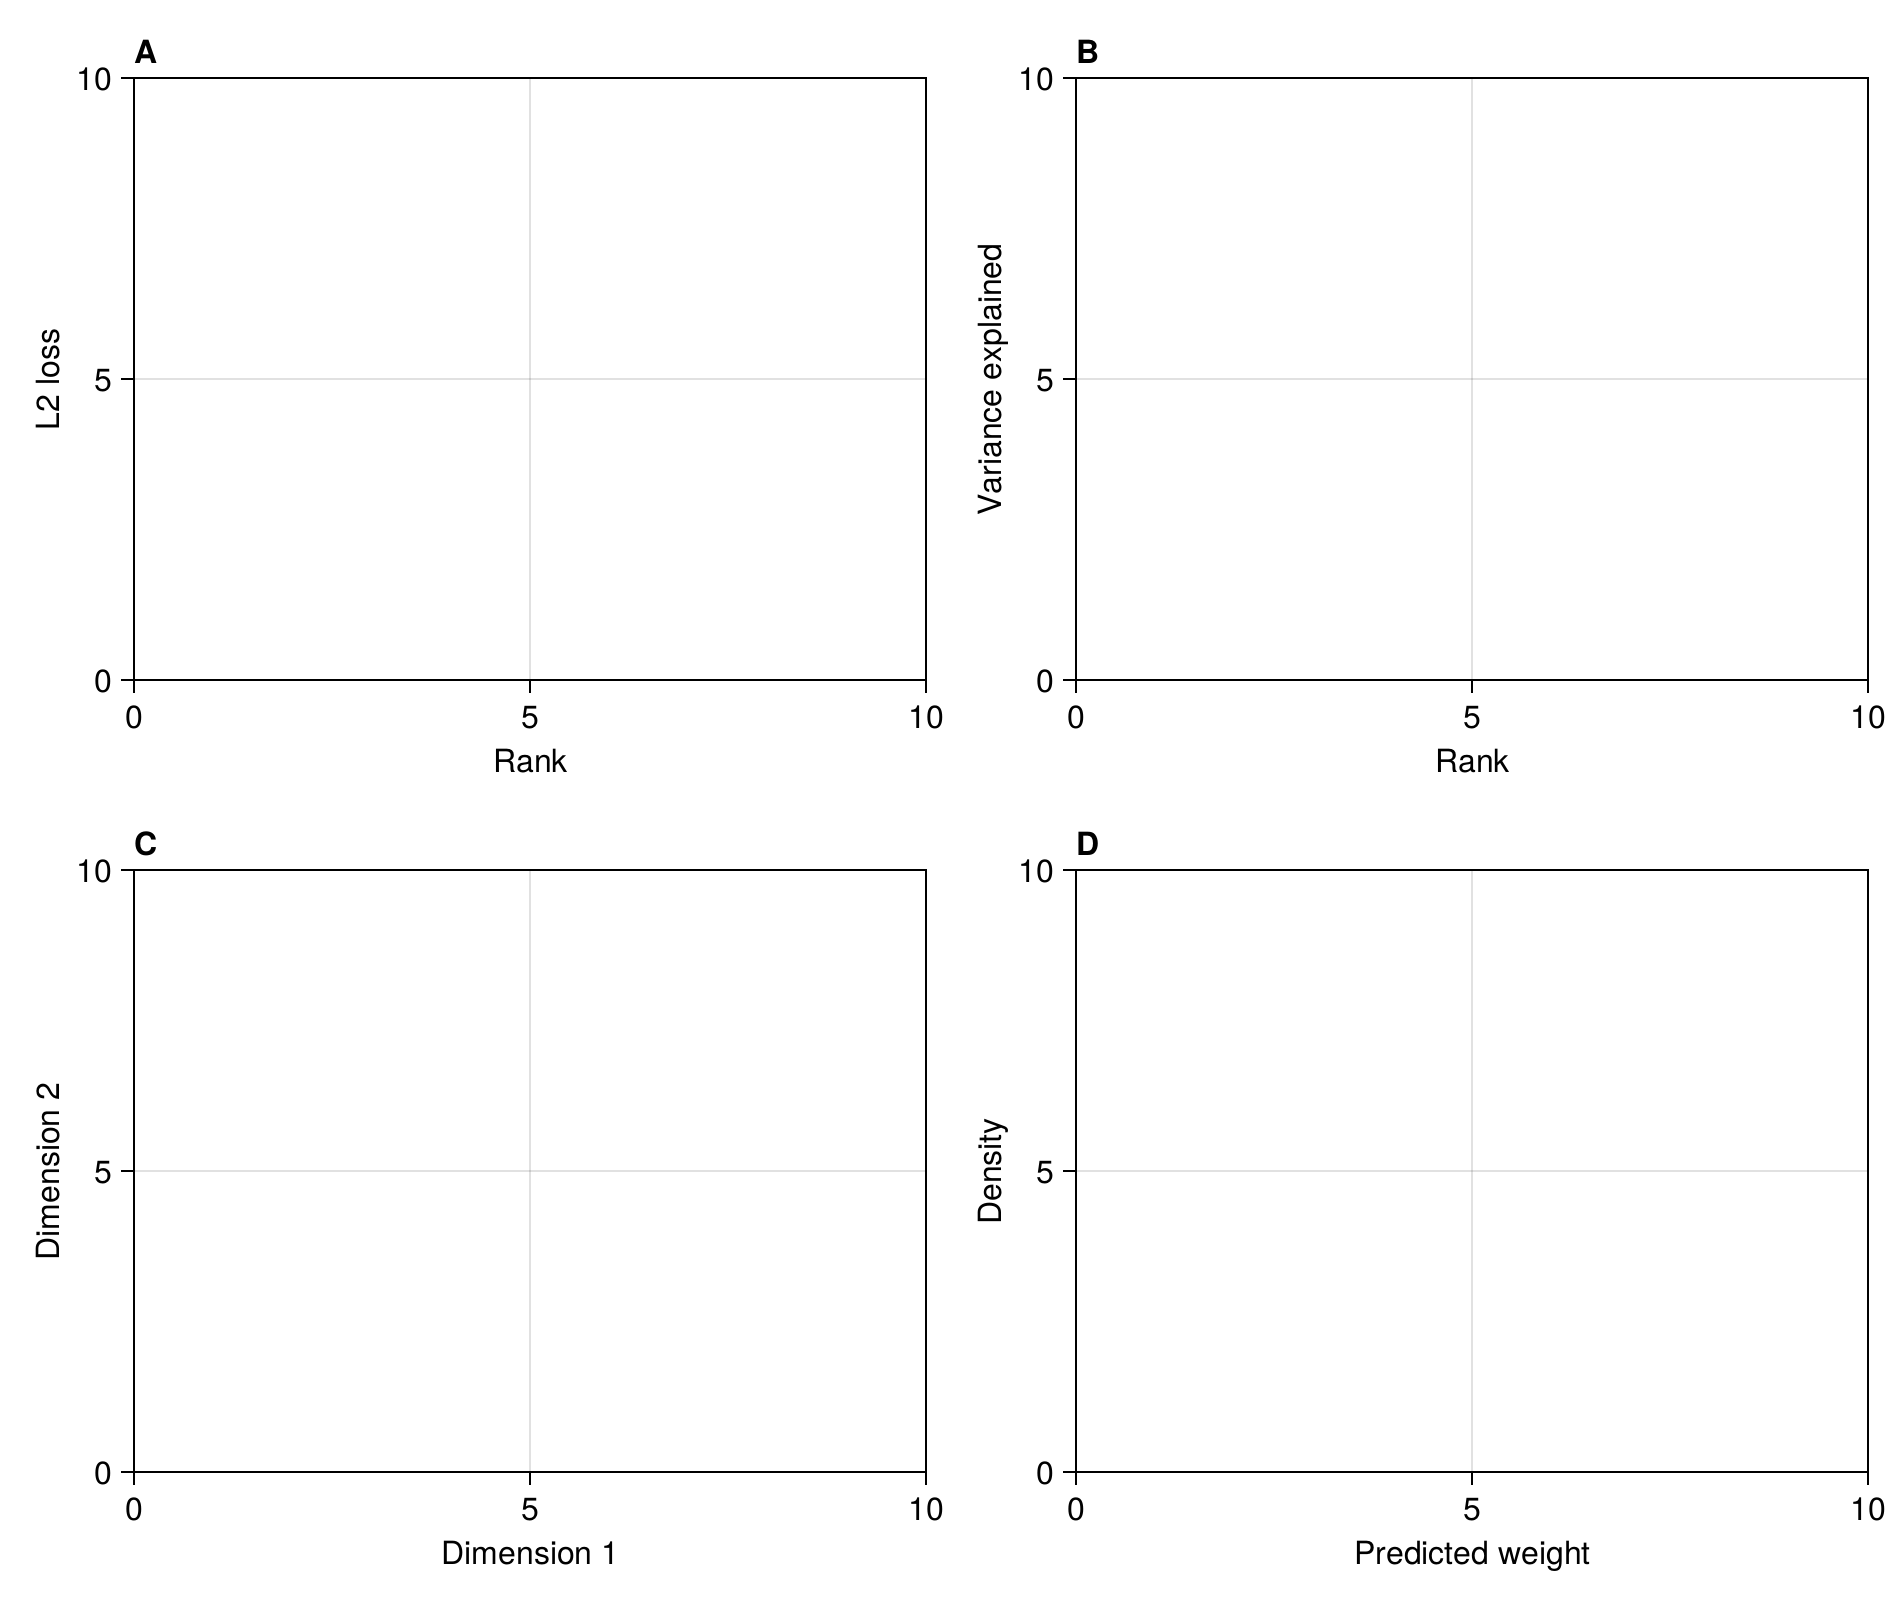

In [123]:
figure1 = Figure(; resolution = (950, 800))
figure1a = Axis(
    figure1[1, 1];
    xlabel = "Rank",
    ylabel = "L2 loss",
    title = "A",
    titlealign = :left,
)
figure1b = Axis(
    figure1[1, 2];
    xlabel = "Rank",
    ylabel = "Variance explained",
    title = "B",
    titlealign = :left,
)
figure1c = Axis(
    figure1[2, 1];
    xlabel = "Dimension 1",
    ylabel = "Dimension 2",
    title = "C",
    titlealign = :left,
)
figure1d = Axis(
    figure1[2, 2];
    xlabel = "Predicted weight",
    ylabel = "Density",
    title = "D",
    titlealign = :left,
)
current_figure()

The first thing we want to do is measure the L2 loss (the sum of squared errors) as a function of the rank. The rank of the metaweb is at most the number of species on its least species-rich side:

In [124]:
rank(adjacency(M))

121

The following list comprehension will perform the RDPG embedding for each rank between 1 and the rank of the metaweb, then multiply the left/right subspaces together to get an approximated network, and report the per-interaction averaged L2 error:

In [125]:
rnk = collect(1:rank(adjacency(M)))
L2 = [sum((adjacency(M) - prod(rdpg(M, r))) .^ 2) ./ prod(size(M)) for r in rnk]

121-element Vector{Float64}:
 0.05744130057895759
 0.0488201549717561
 0.044182471764921294
 0.04014623856002384
 0.03731319071666472
 0.035036091173708594
 0.033129096411421304
 0.03128810293334584
 0.029824448518954886
 0.028485820019597416
 ⋮
 4.756534964035326e-5
 3.871435018435366e-5
 3.077568517320694e-5
 2.3762477728538295e-5
 1.728209478741771e-5
 1.1040542326391507e-5
 5.9908504730463834e-6
 2.6163841056681962e-6
 3.383682609541635e-30

We add this to the first panel of the figure:

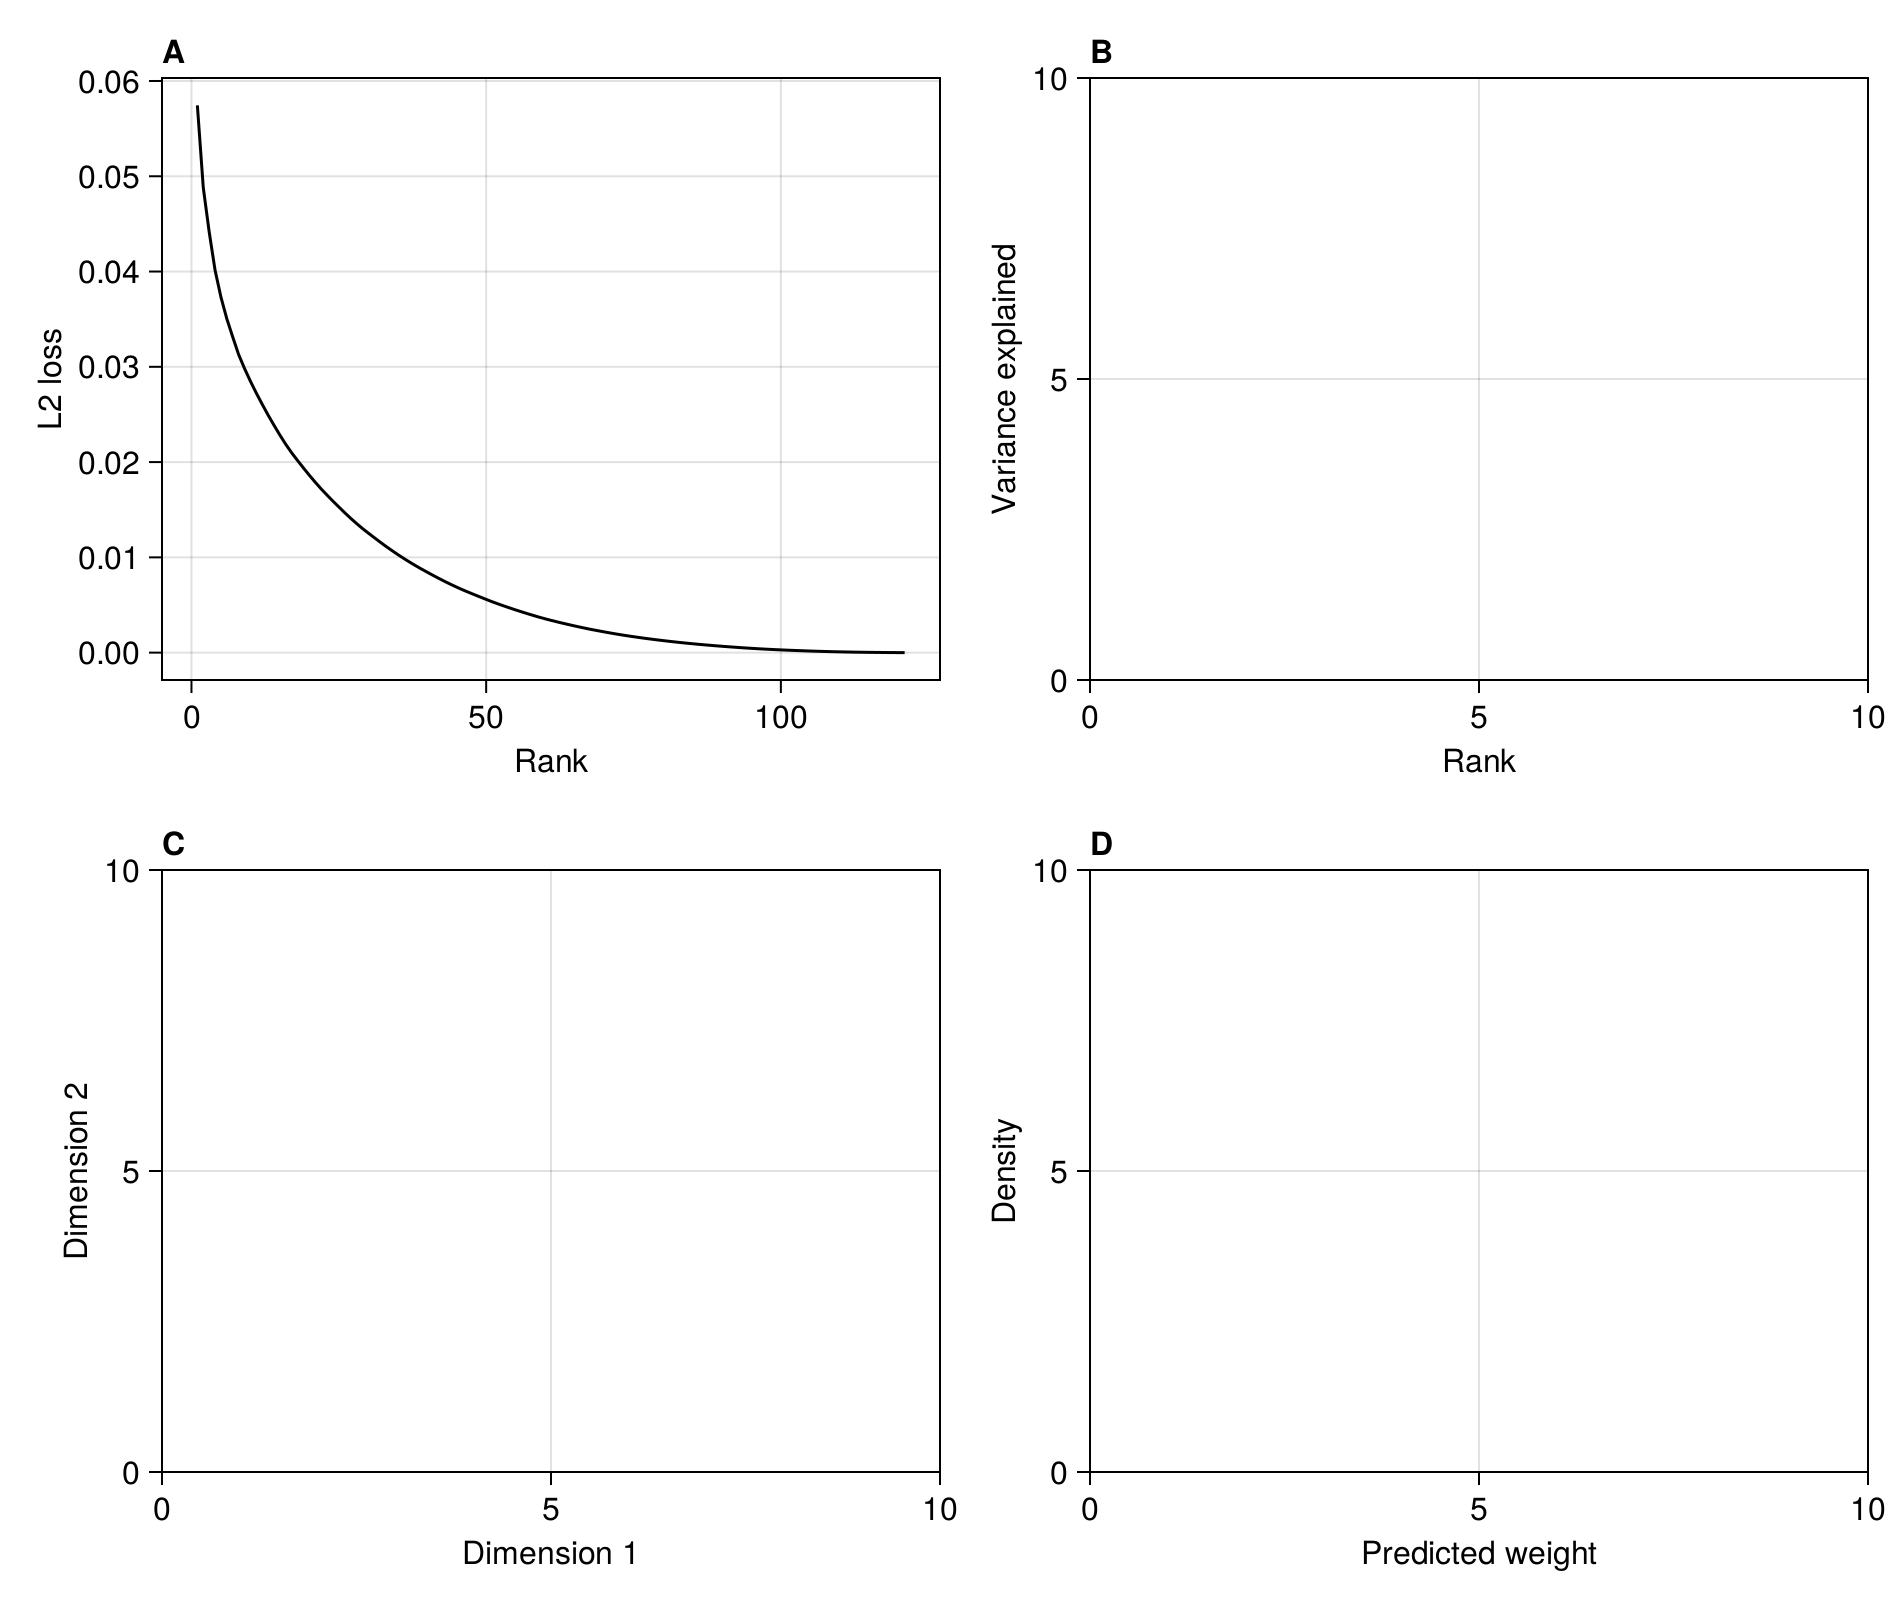

In [126]:
lines!(figure1a, rnk, L2; color = :black)
current_figure()

In order to identify the point of inflexion at which to perform the embedding, we could calculate the second order derivate of the loss function w.r.t. rank, using the approximation provided by the finite differences method, for which there are closed form solutions for the first (forward difference), last (backward difference), and any (central difference point). This can be done on the singular values of the SVD yielding the RDPG used for the embedding:

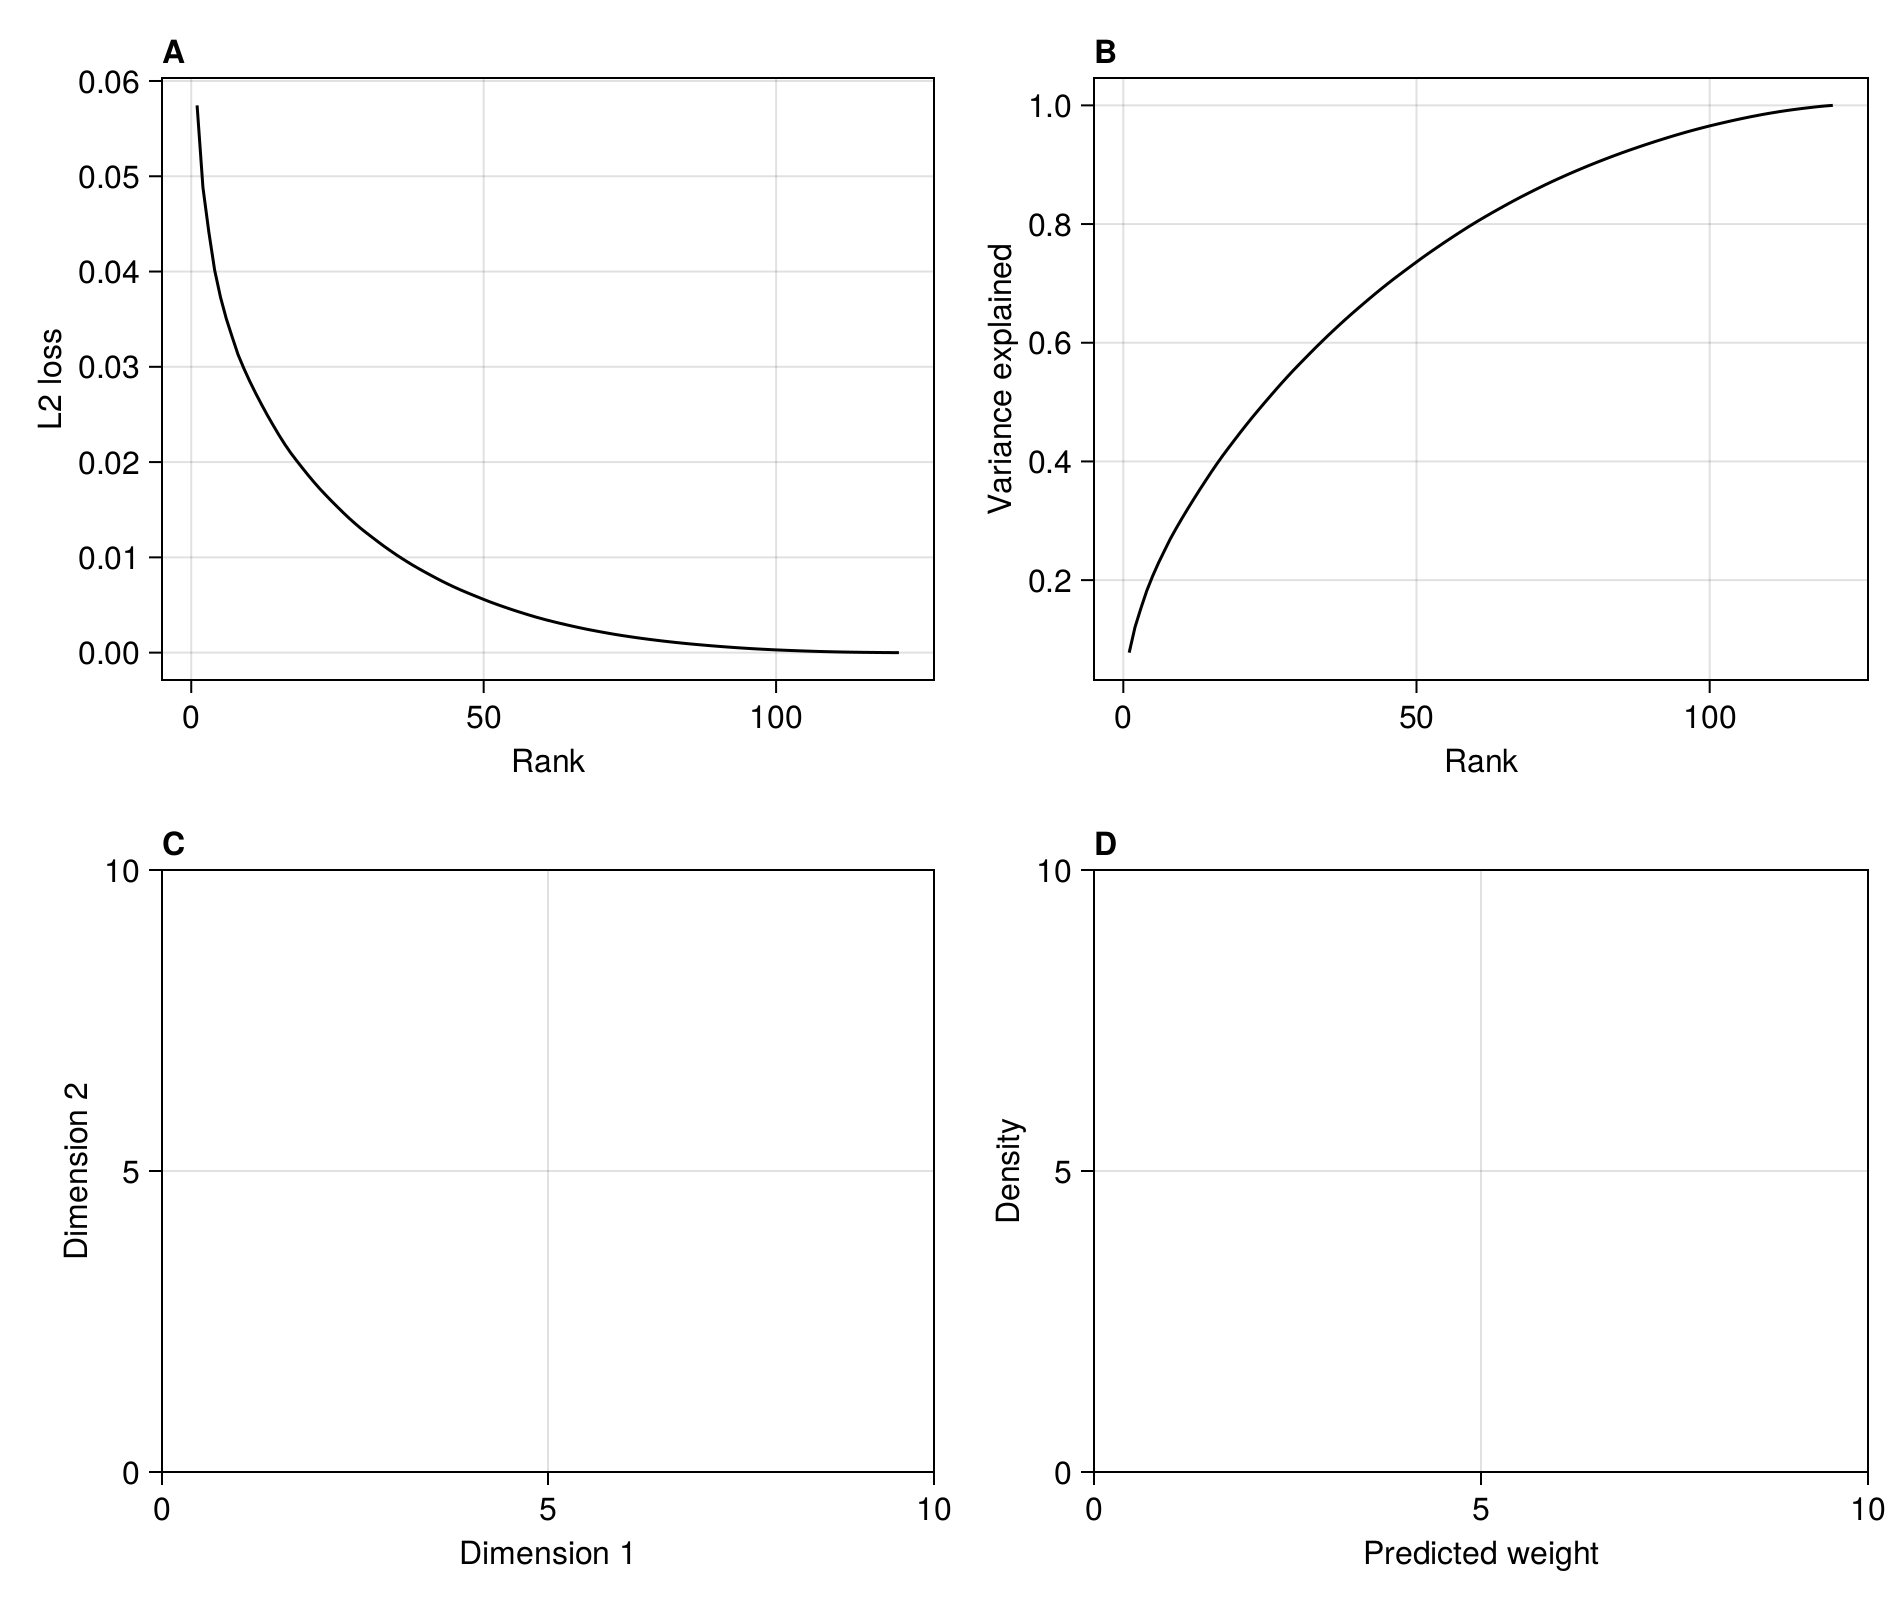

In [127]:
singularvalues = svd(adjacency(M)).S
lines!(
    figure1b,
    rnk,
    cumsum(singularvalues) ./ sum(singularvalues); color = :black,
)
current_figure()

The finite differences methods to get the inflexion points proper is simply given by:

In [128]:
sv = copy(singularvalues)
D = zeros(size(L2))
for i in axes(D, 1)
    if i == 1
        D[i] = sv[i + 2] - 2sv[i + 1] + sv[i]
    elseif i == length(D)
        D[i] = sv[i] - 2sv[i - 1] + sv[i - 2]
    else
        D[i] = sv[i + 1] - 2sv[i] + sv[i - 1]
    end
end

In practice, the screeplot of variance explained by each rank is noisy, meaning that the correct inflexion point is not necessarilly obvious from the series of second order derivatives (themselves an approximation due to the finite differences method). Here, we are placing the inflexion point at the value that is closest to 0 (in absolute value) - this is a slightly conservative approach that will keep more dimensions, but provide a better approximation of the network.

In [129]:
embedding_rank = last(findmin(abs.(D)))

39

We can add it to the figure:

In [130]:
scatter!(figure1a, [embedding_rank], [L2[embedding_rank]]; color = :black)
scatter!(
    figure1b,
    [embedding_rank],
    [(cumsum(singularvalues) ./ sum(singularvalues))[embedding_rank]];
    color = :black,
)

Scatter{Tuple{Vector{Point{2, Float32}}}}

In the next steps, we will perform the RDPG embedding at this rank. We can check the L2 loss associated with this representation:

In [131]:
L2[embedding_rank]

0.008781432658004353

The left/right subspaces are given by the `rdpg` function, which internally performs a t-SVD and then multiply each side by the square root of the eigenvalues:

In [132]:
L, R = rdpg(M, embedding_rank)

([-0.31286375720303533 -0.043030881301210994 … 0.13089538016786548 -0.20429603515164355; -0.13639064534793804 -0.069120397590513 … -0.022693347528150234 0.11122052820015549; … ; -0.07325950183520884 0.055523273646558215 … 0.009841316351827679 -0.01931207868006777; -0.037791712381080346 0.03795436890539979 … 0.07396177101652388 -0.10508157577475588], [-1.484396333351671 -0.6088099455780831 … -0.18331412712563155 -0.018557865543628753; -0.06204291742899854 0.07811536918416419 … -0.0649963044402432 -0.004540292268812767; … ; -0.15780083148368063 0.030858539181893643 … 0.23635721814746793 -0.039464787454680156; 0.11993993308033085 -0.2685421627054579 … 0.007877516594161235 0.10605965189104812])

Checking the sizes of the L and R subspaces is important. For example, the size of L is:

In [133]:
size(L)

(206, 39)

The number of rows (parasite richness) and columns (subspaces dimensions) is correct, so we can move on to the next step (doing the same exercise for R will show why the L\*R multiplication will give back a matrix of the correct dimension). We will approximate the network at the previously identified rank, and call it P:

In [134]:
P = clamp.(L * R, 0., 1.)

206×121 Matrix{Float64}:
 1.0        1.0         0.199705    …  0.0854123   0.0360167   0.0
 1.0        1.0         0.49918        0.0130665   0.0         0.0
 0.869676   0.843036    0.347334       0.0         0.0275938   0.0
 0.995816   1.0         0.85884        0.0         0.0         0.0242046
 0.968721   1.0         0.198935       0.0342837   0.0         0.0
 1.0        1.0         0.805771    …  0.0894987   0.0         0.0670649
 0.116086   0.957751    0.149858       0.0375512   0.0         0.0
 0.950946   1.0         0.12715        0.0514532   0.0         0.0
 1.0        1.0         0.0514726      0.0         0.0454504   0.0850339
 1.0        0.938797    0.249431       0.0         0.0         0.0107727
 ⋮                                  ⋱                          ⋮
 0.0        0.0353385   0.0            0.0         0.00455419  0.0
 0.0        0.0353385   0.0            0.0         0.00455419  0.0
 0.0        0.0353385   0.0            0.0         0.00455419  0.0
 0.0        0.0

With this matrix, we can start looking at the weight given for (i) positive interactions, (ii) interactions that are never observed but for which the species pair is observed at least once, and (iii) species pairs that are never observed. We simply plot the desntiy for each of these three situations and add it to the figure:

In [135]:
noc = density!(figure1d, P[findall(iszero.(C))])
pos = density!(figure1d, P[findall(adjacency(M))])
neg = density!(figure1d, P[findall(iszero.(adjacency(M)) .& .~iszero.(C))])
axislegend(
    figure1d,
    [pos, neg, noc],
    ["Interactions", "Non-interactions", "No co-occurence"],
)

Legend()

From this panel, it is rather clear that a lot of interactions without documented co-occurrence have a lower assigned weight, and are therefore less likely to be feasible. Turning this information into a prediction of interaction existence can be carried out as a binary classification exercise using *e.g.* weight thresholding.

Another potentially useful visualisation is to look at the position of each species on the first/second dimension of the relevant subspace.

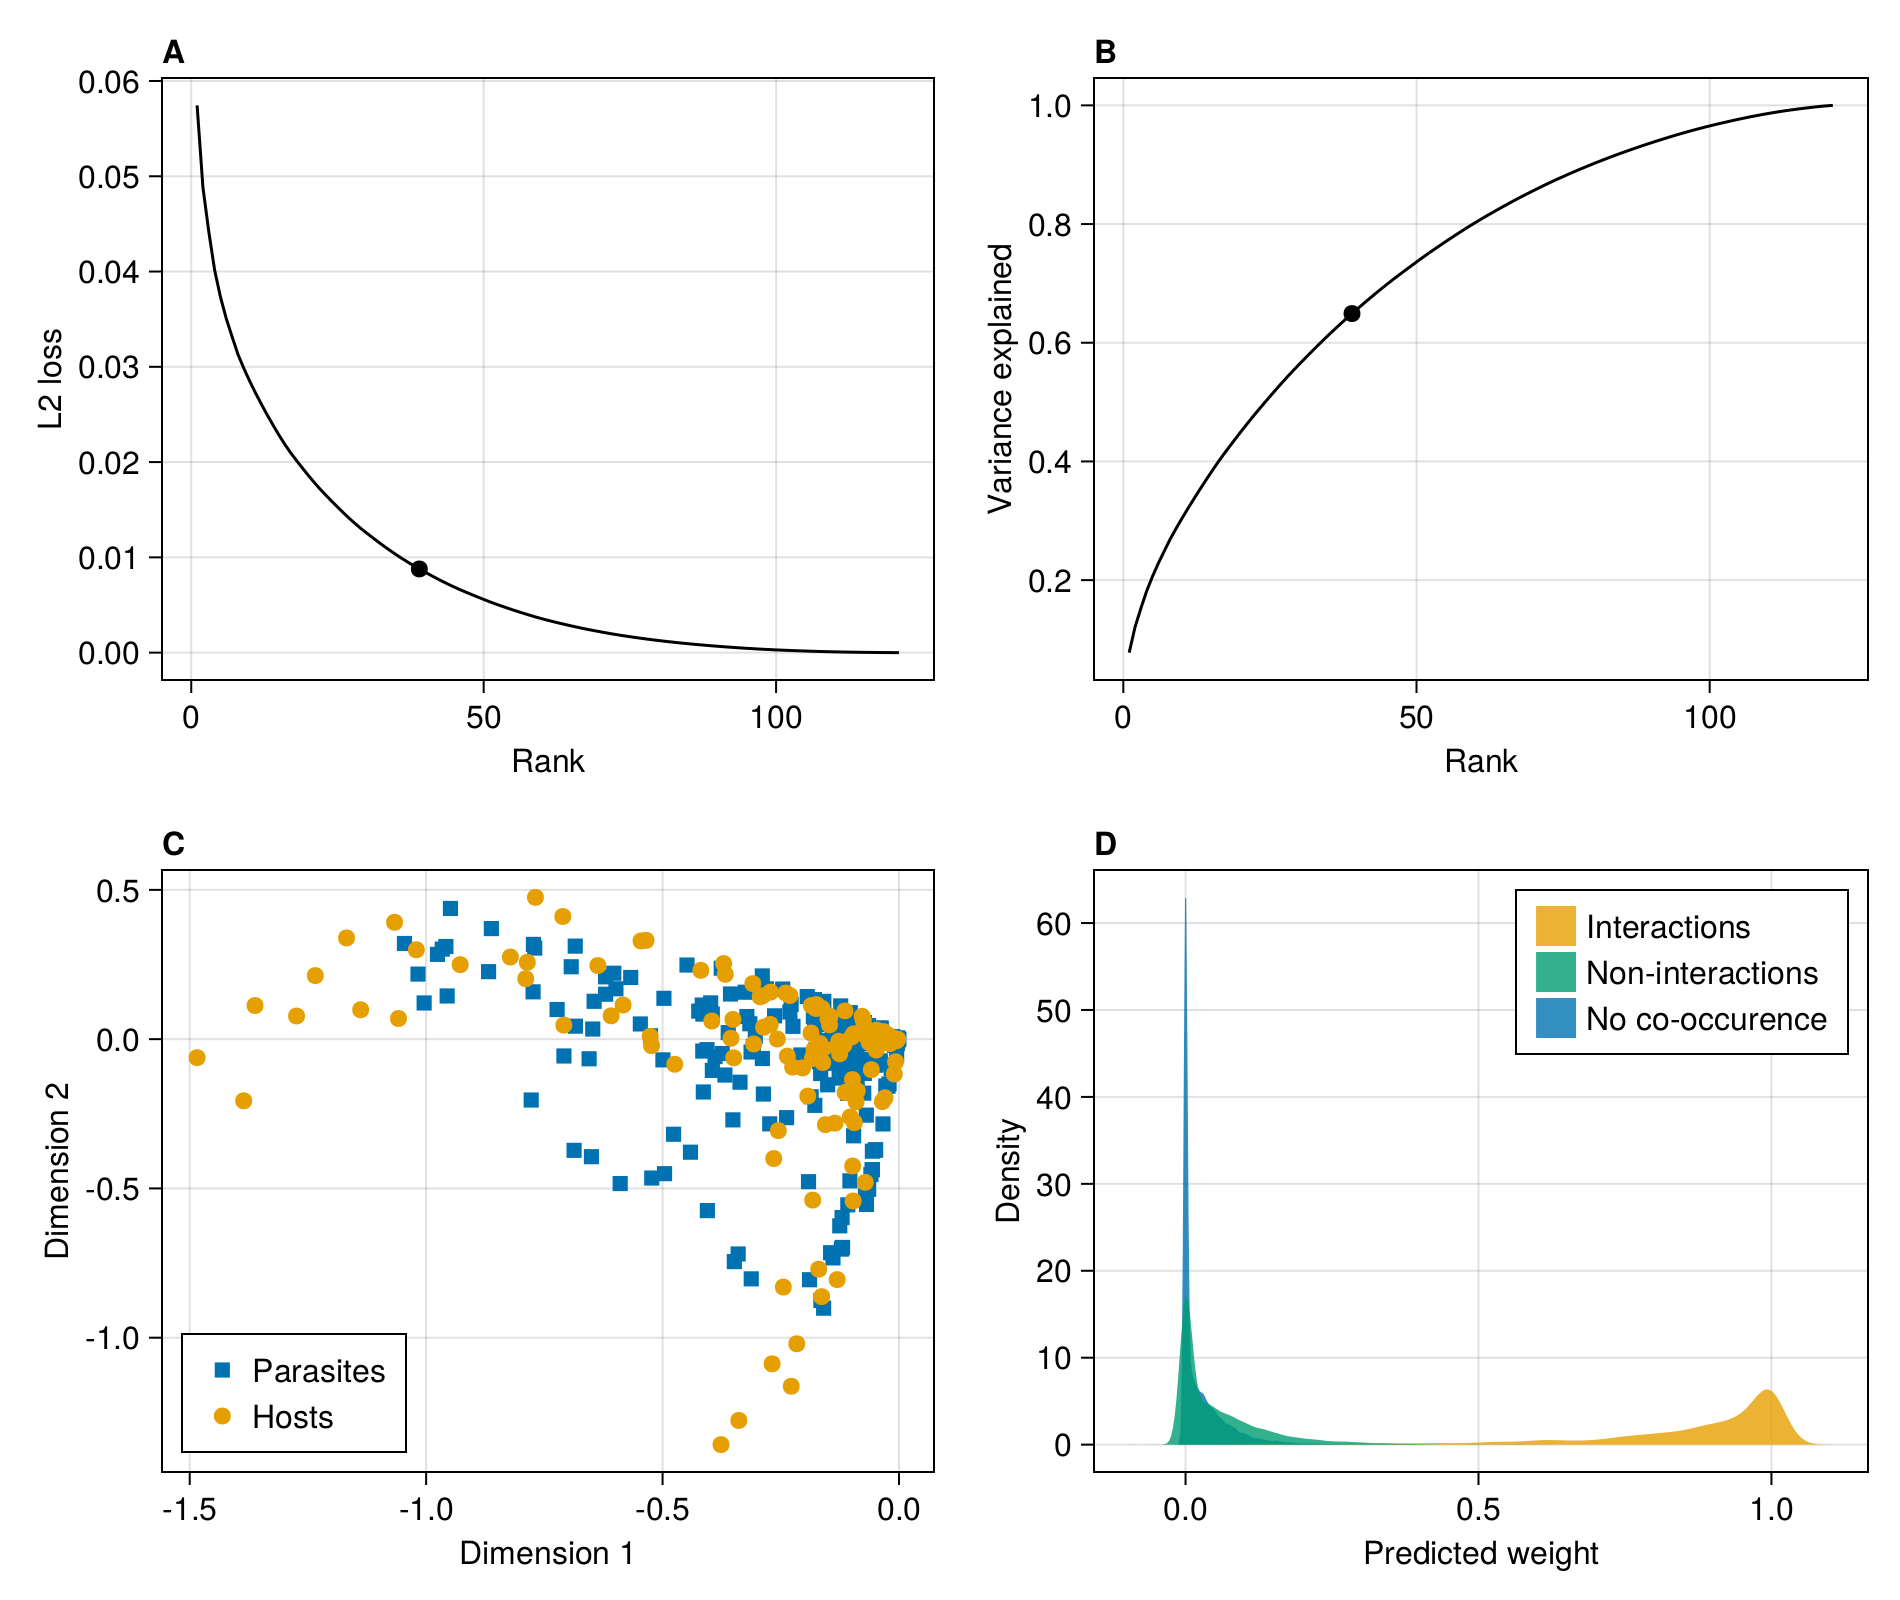

In [136]:
para = scatter!(figure1c, L[:, 1], L[:, 2]; marker = :rect)
host = scatter!(figure1c, R'[:, 1], R'[:, 2])
axislegend(figure1c, [para, host], ["Parasites", "Hosts"]; position = :lb)
current_figure()

We finally save a high-dpi version of the first figure to disk:

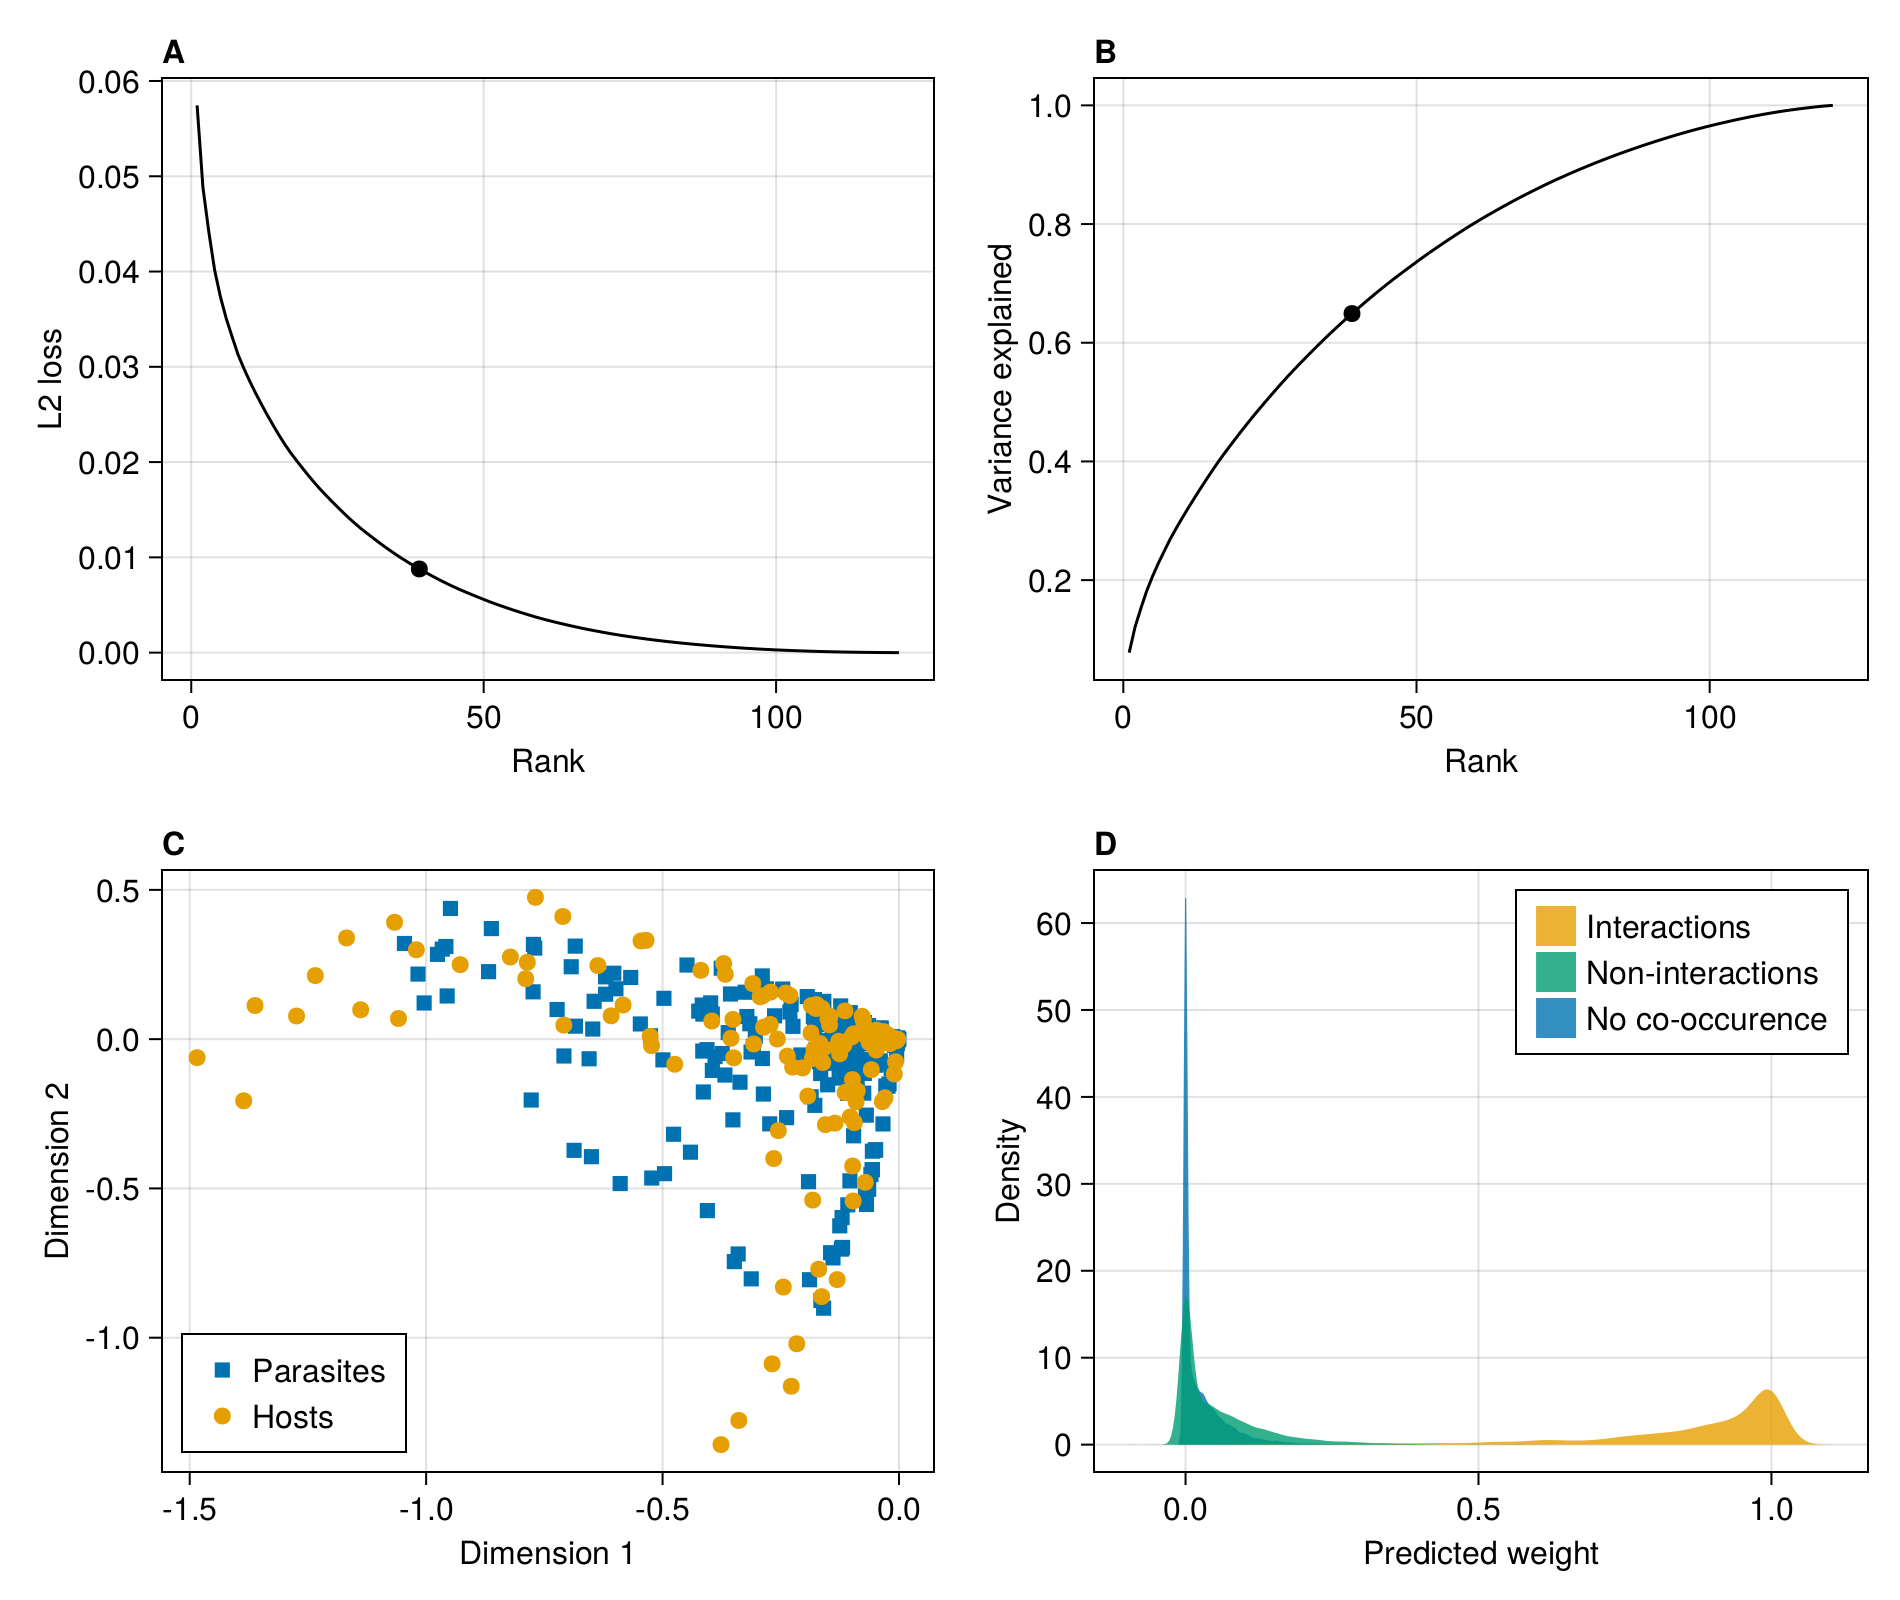

In [137]:
current_figure()

In the second figure, we will relate the embedding information to taxonomic/ecological information about the species, using hosts as an illustration:

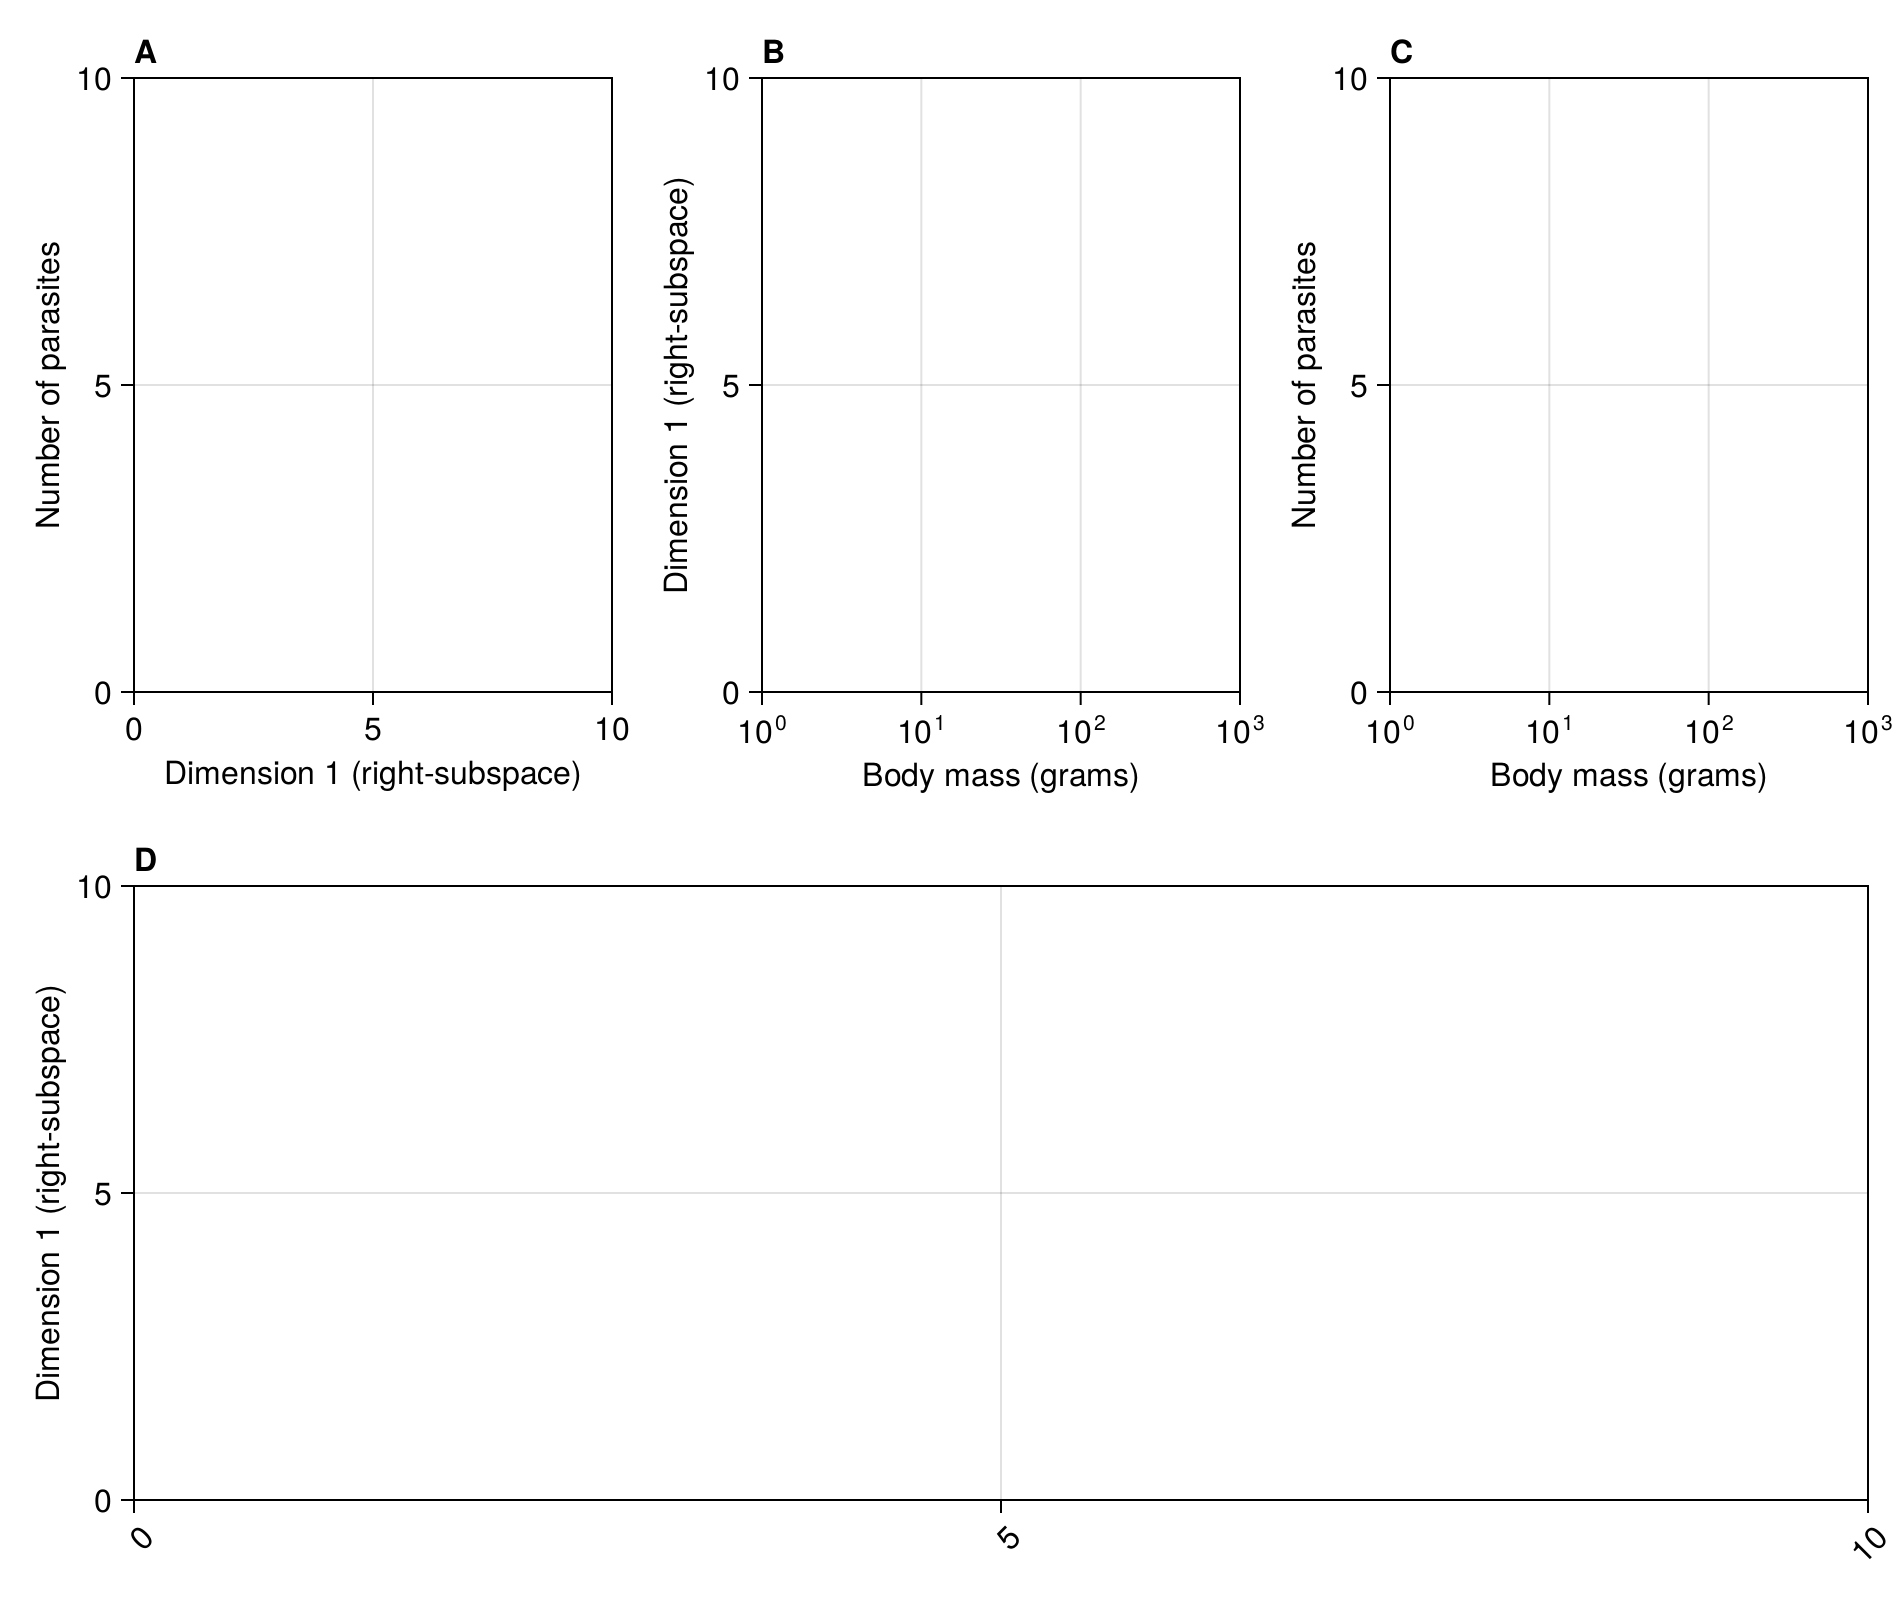

In [138]:
figure2 = Figure(; resolution = (950, 800))
figure2a = Axis(
    figure2[1, 1];
    xlabel = "Dimension 1 (right-subspace)",
    ylabel = "Number of parasites",
    title = "A",
    titlealign = :left,
)
figure2b = Axis(
    figure2[1, 2];
    ylabel = "Dimension 1 (right-subspace)",
    xlabel = "Body mass (grams)",
    xscale = log10,
    title = "B",
    titlealign = :left,
)
figure2c = Axis(
    figure2[1, 3];
    ylabel = "Number of parasites",
    xlabel = "Body mass (grams)",
    xscale = log10,
    title = "C",
    titlealign = :left,
)
figure2d = Axis(
    figure2[2, 1:3];
    ylabel = "Dimension 1 (right-subspace)",
    title = "D",
    titlealign = :left,
    xticklabelrotation = π / 4,
)
current_figure()

We can now link the position on the first dimension to ecologically relevant information, like *e.g.* the number of parasites.

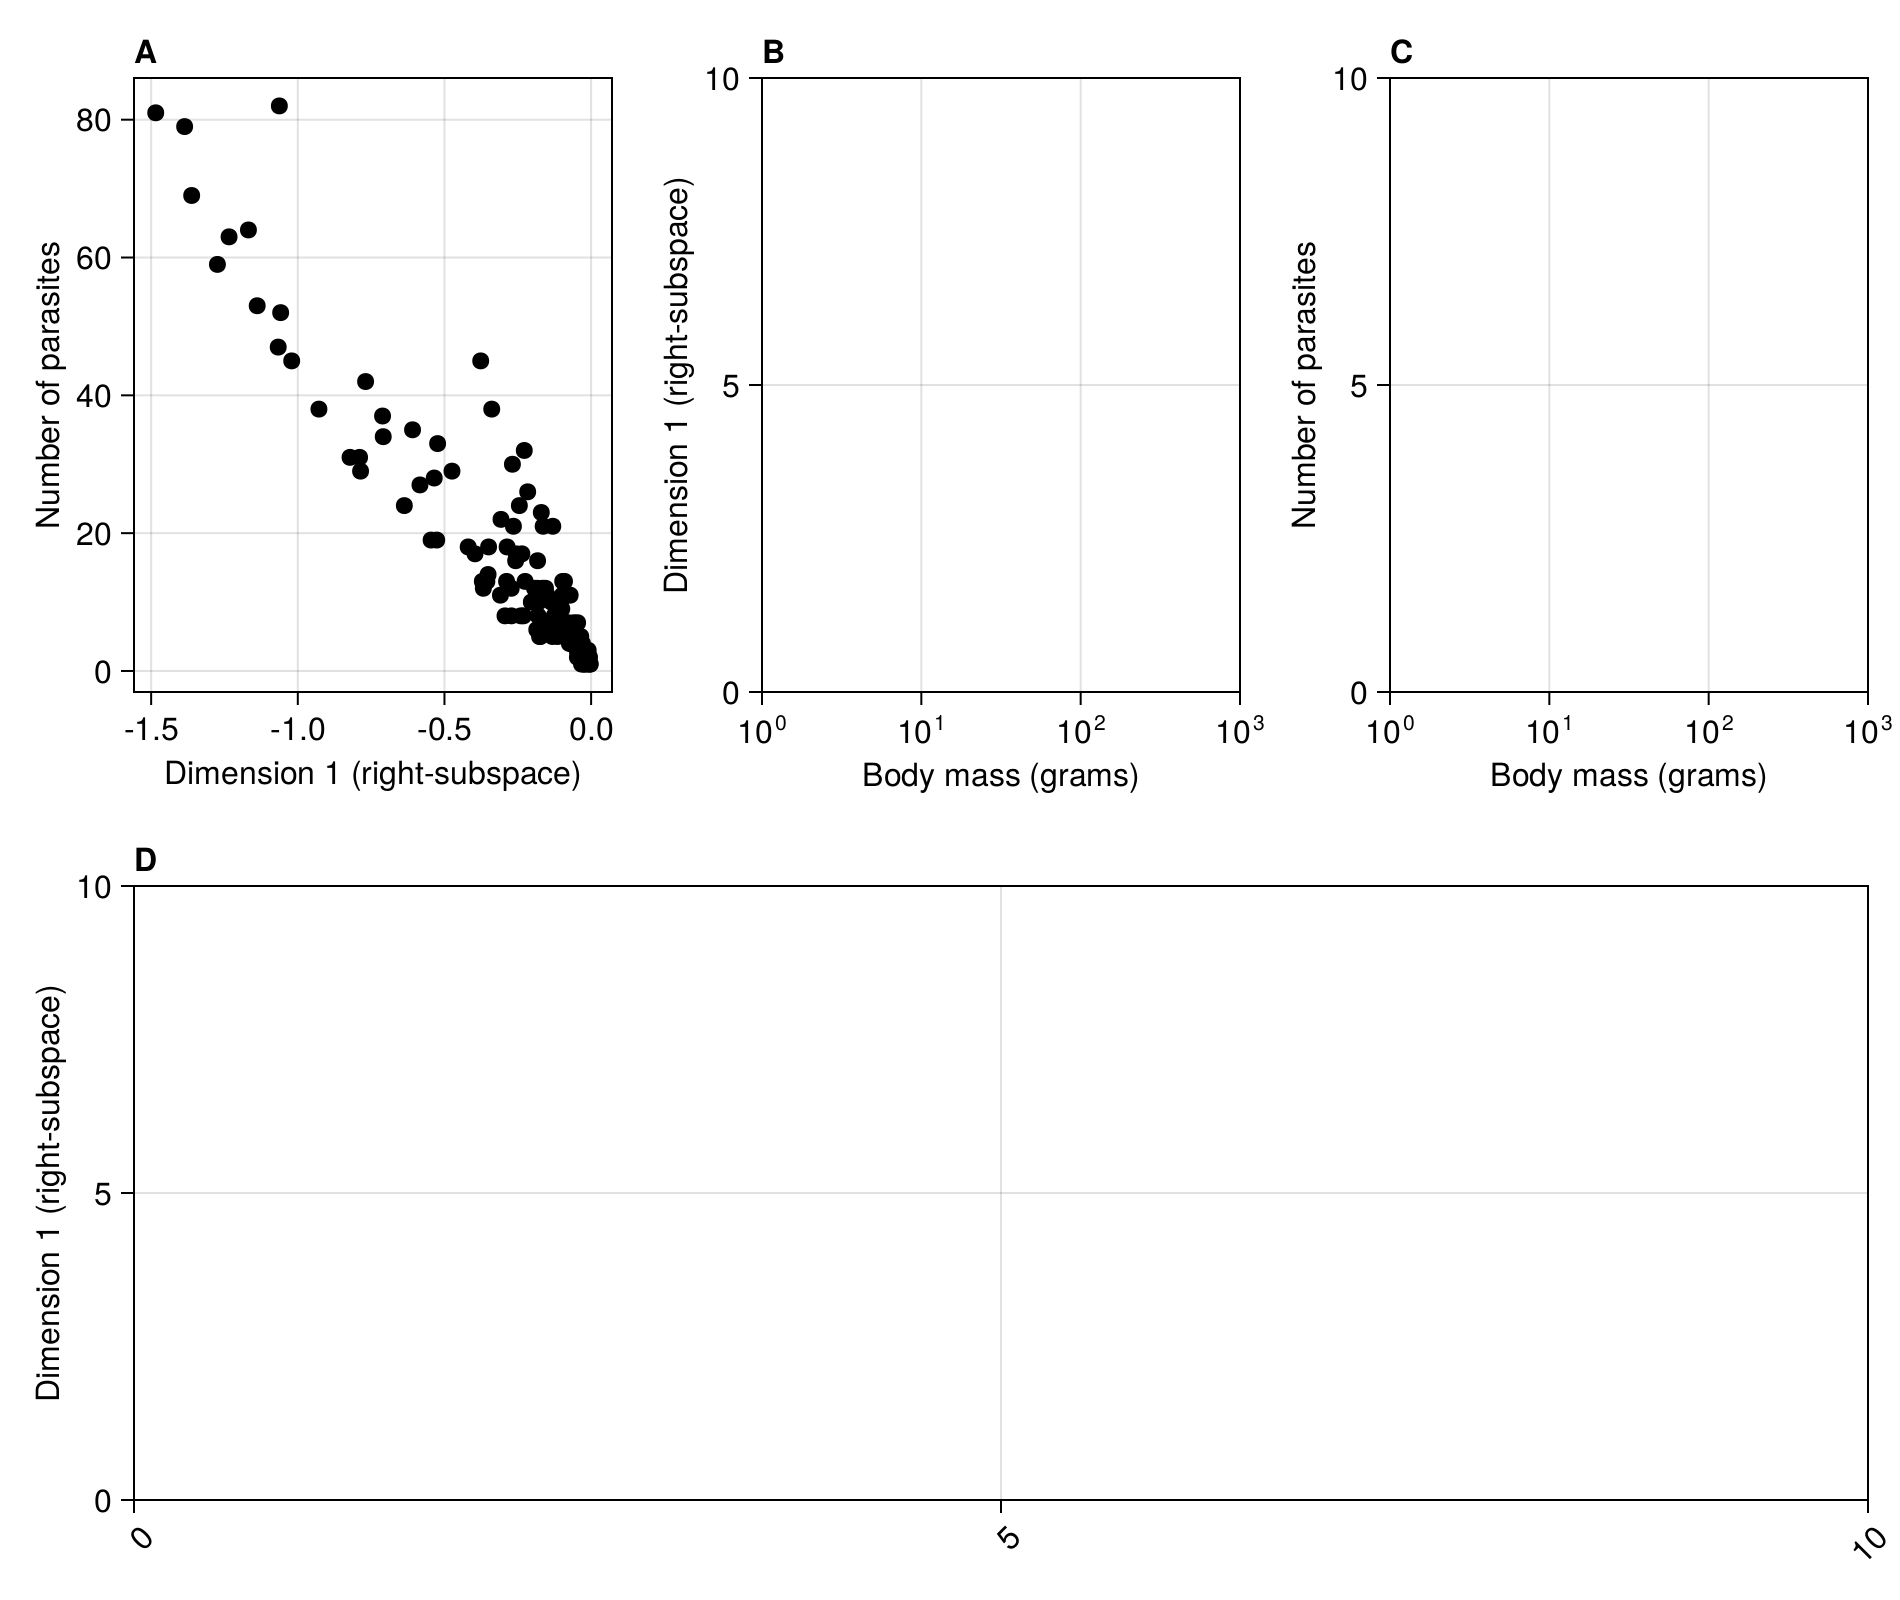

In [139]:
scatter!(figure2a, R[1, :], vec(sum(adjacency(M); dims = 1)); color = :black)
current_figure()

We will now load the PanTHERIA database to get metadata and functional traits on host species:

In [140]:
pantheria = DataFrame(CSV.File(joinpath("..", "code", "PanTHERIA_1-0_WR05_Aug2008.txt")))

We can match the PanTHERIA rows with species names, and extract the columns we will use: species name, family, position on the first dimension, and finally bodymass:

In [141]:
vidx = filter(!isnothing, indexin(species(M; dims = 2), pantheria.MSW05_Binomial))
rodents = pantheria[vidx, :]
species_index = indexin(rodents.MSW05_Binomial, species(M; dims = 2))
rodents.dim1 = R[1, species_index]
rodents.prich = [degree(M)[k] for k in rodents.MSW05_Binomial]

@select!(
    rodents,
    :species = :MSW05_Binomial,
    :family = :MSW05_Family,
    :dimension = :dim1,
    :parasites = :prich,
    :bodymass = $(Symbol("5-1_AdultBodyMass_g"))
)

rodents = @orderby(rodents, :family)

We can plot the positions on the first dimension by taxonomic family (outliers do not appear on the boxplots):

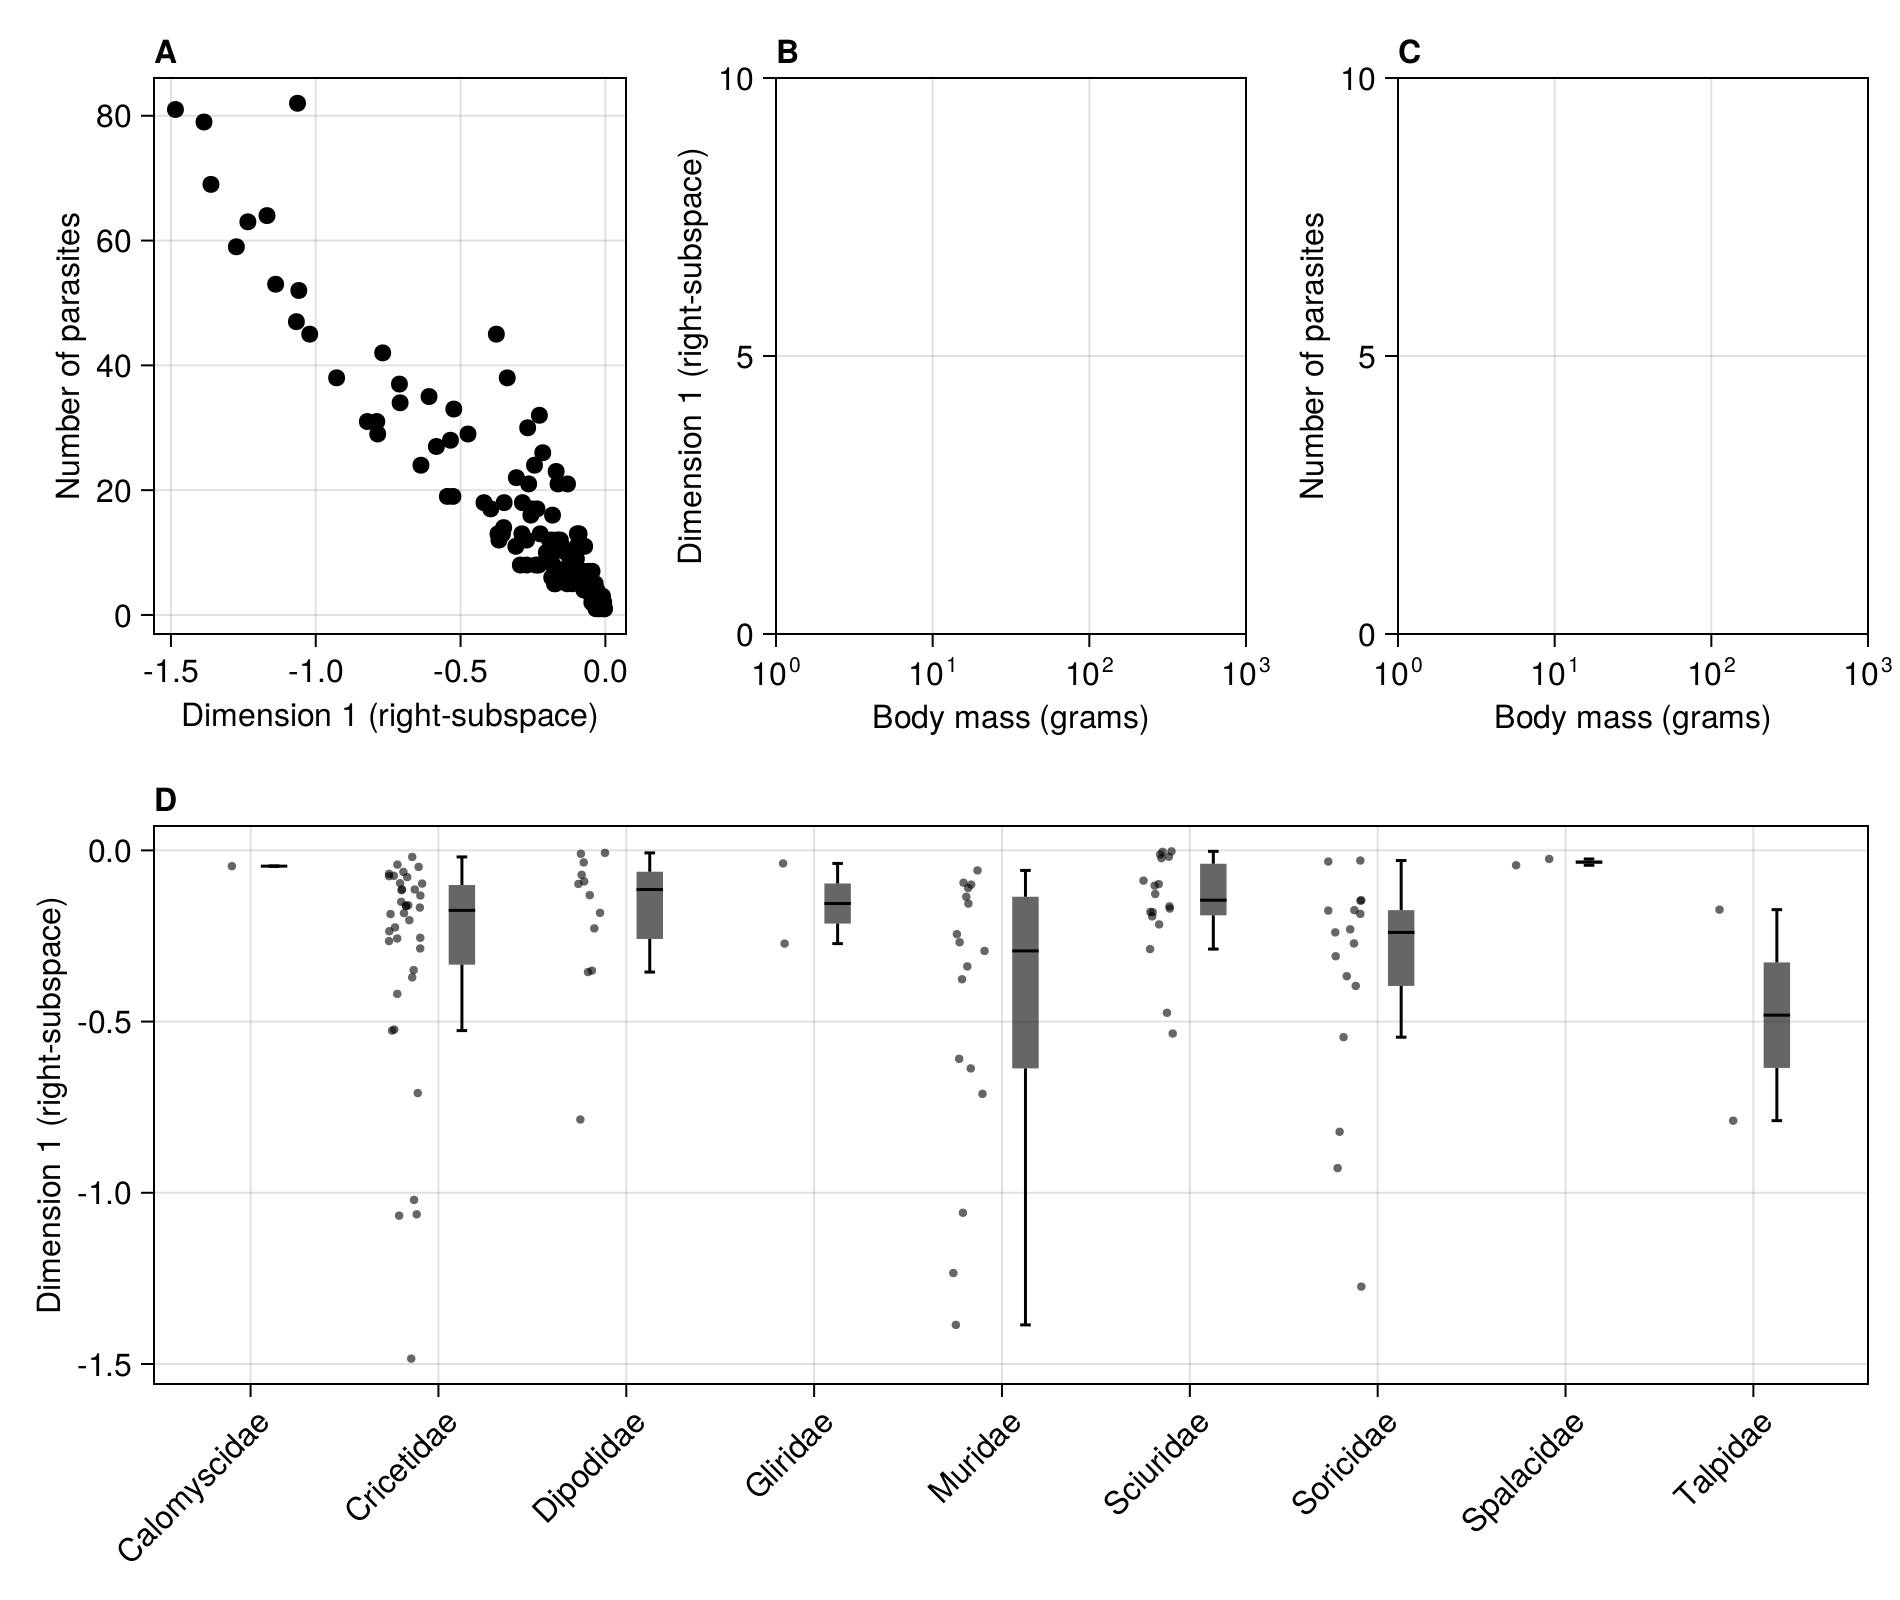

In [142]:
rainclouds!(
    figure2d,
    rodents.family,
    rodents.dimension;
    plot_boxplots = true,
    boxplot_width = 0.22,
    boxplot_nudge = 0.25,
    strokewidth = 0.0,
    clouds = nothing,
    datalimits = extrema,
    orientation = :vertical,
    markersize = 6,
    side_nudge = -0.125,
    jitter_width = 0.22,
)
current_figure()

To examine the relationship with functional traits, we remove the species with no known bodymass:

In [143]:
@subset!(rodents, :bodymass .>= 0.0)

And we can finally plot this as the last panel of the figure:

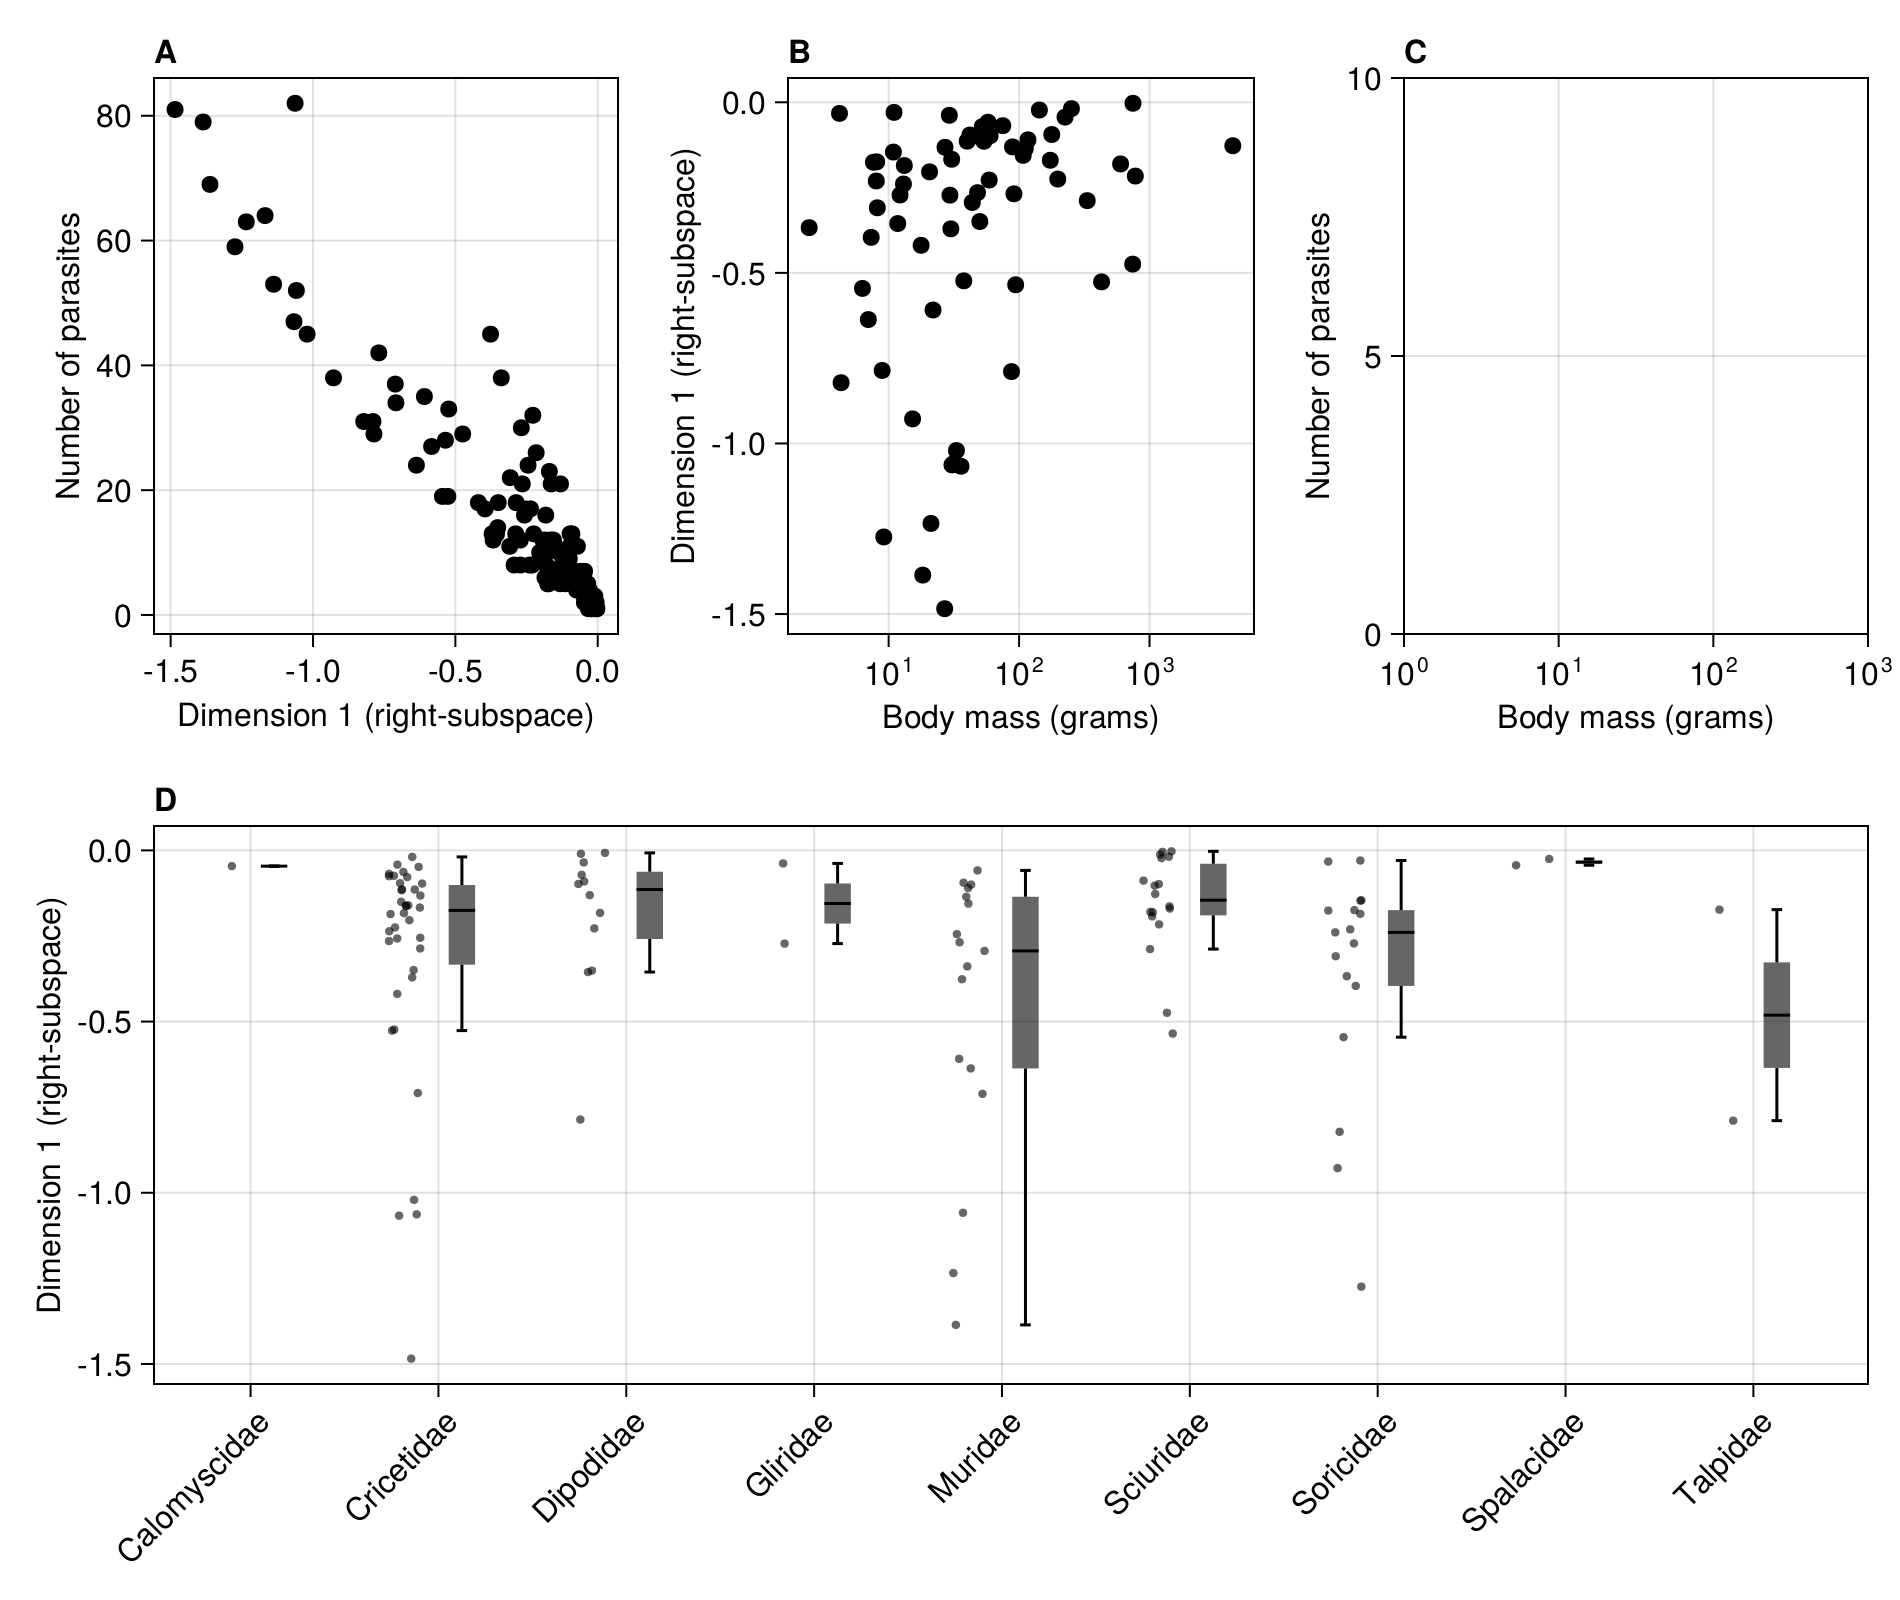

In [144]:
scatter!(
    figure2b,
    rodents.bodymass,
    rodents.dimension;
    color = :black,
)
current_figure()

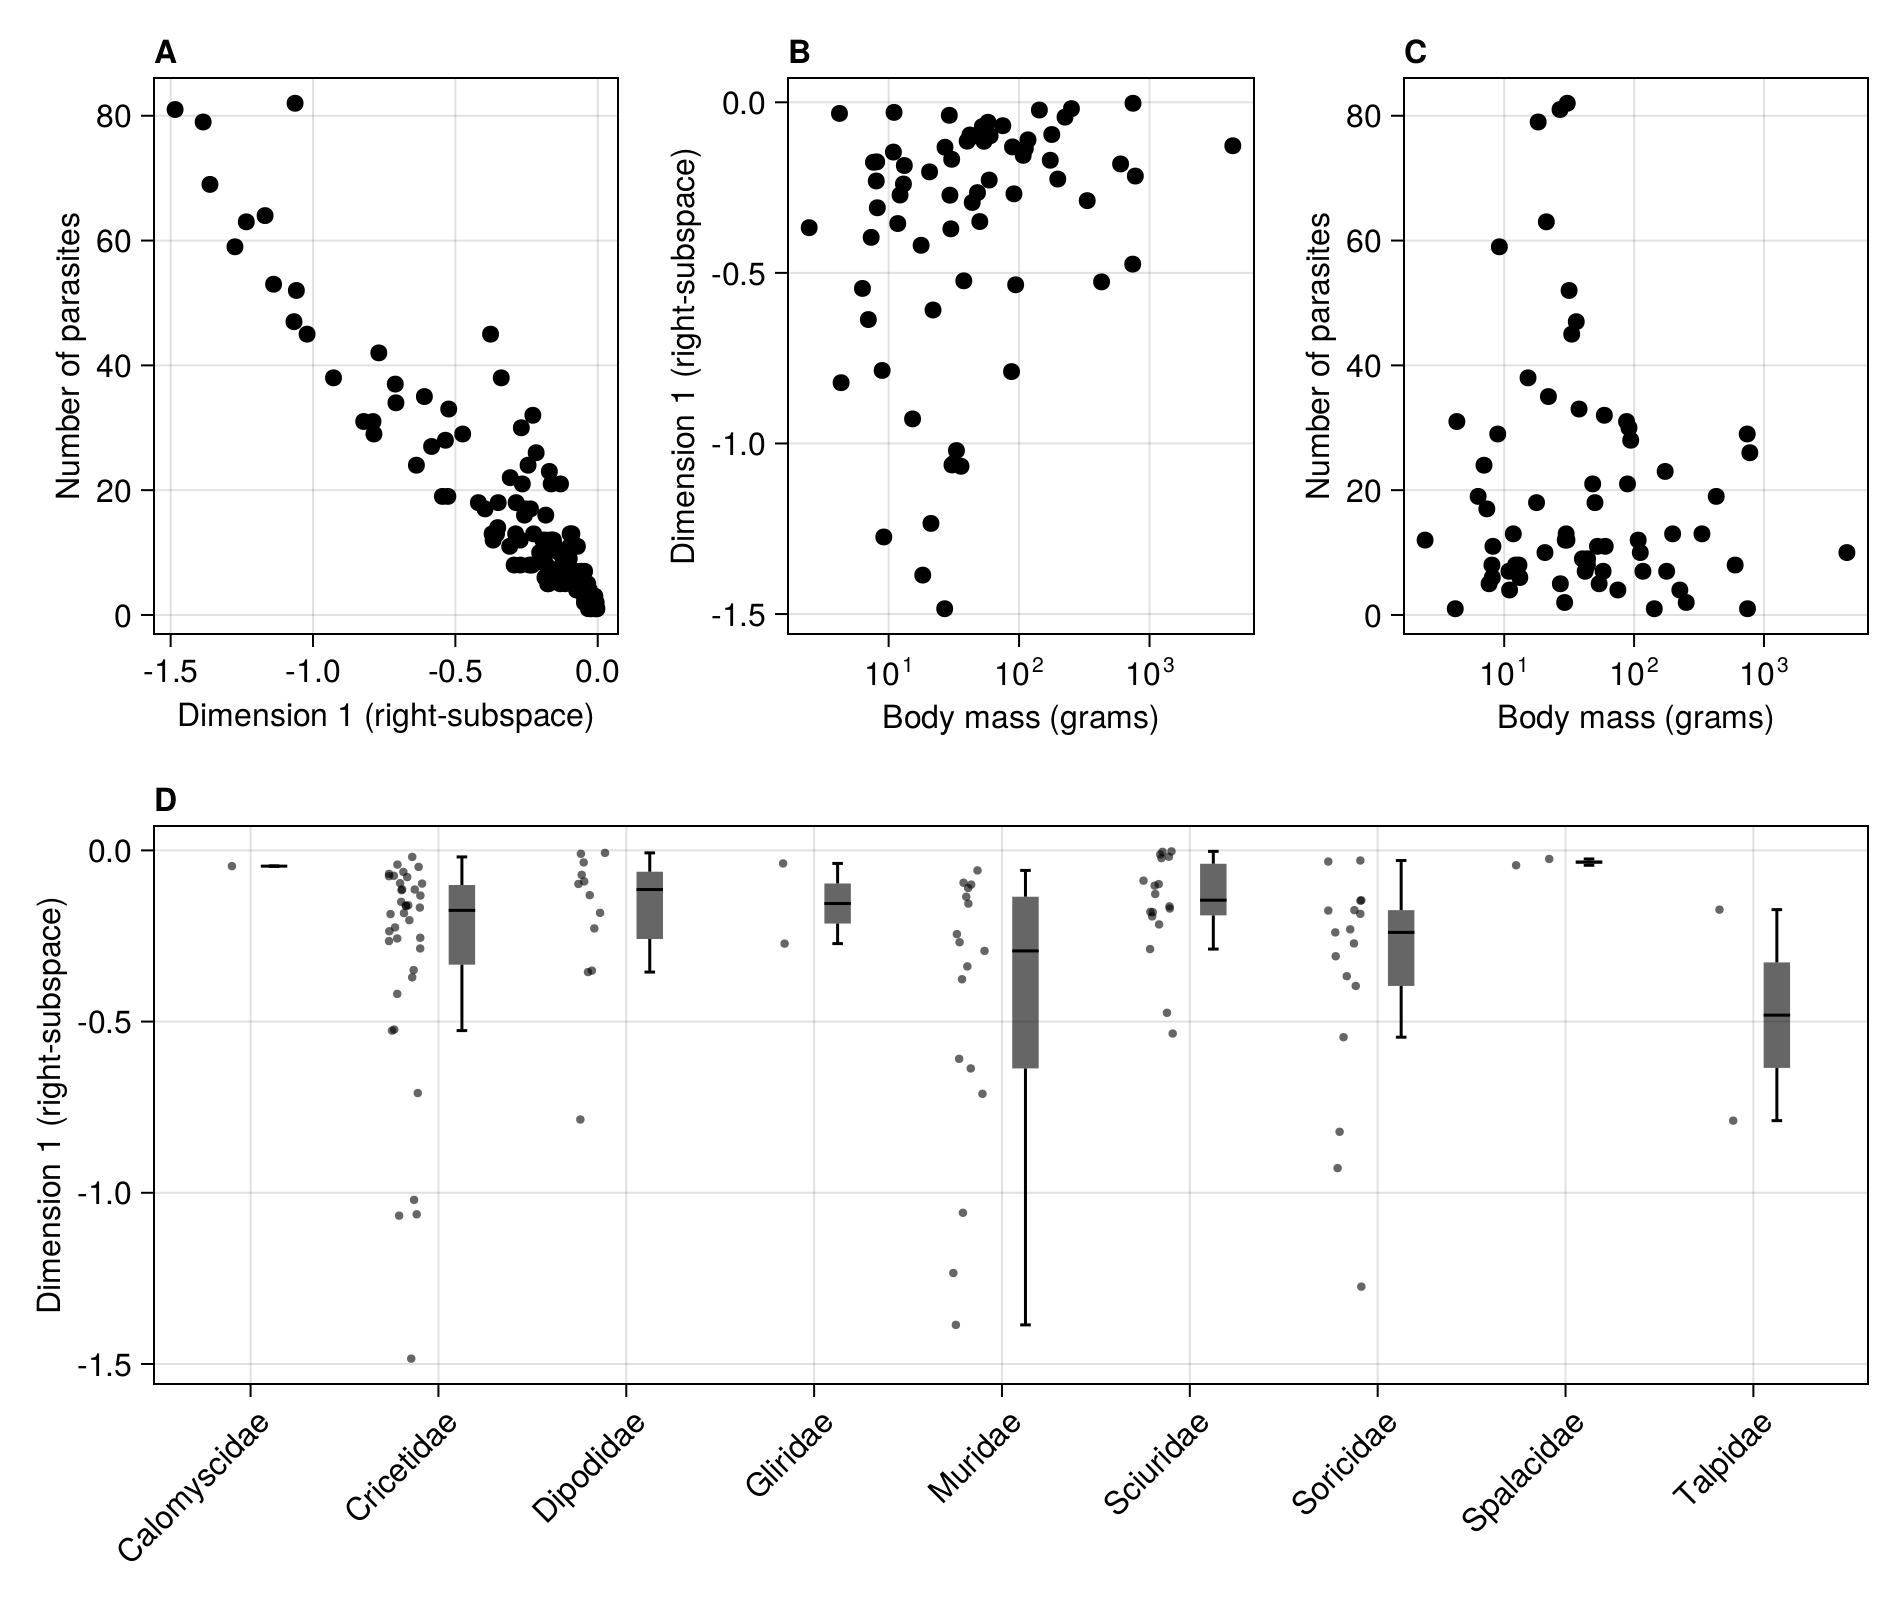

In [145]:
scatter!(
    figure2c,
    rodents.bodymass,
    rodents.parasites;
    color = :black,
)
current_figure()

We save the figure to disk in the same way as before:

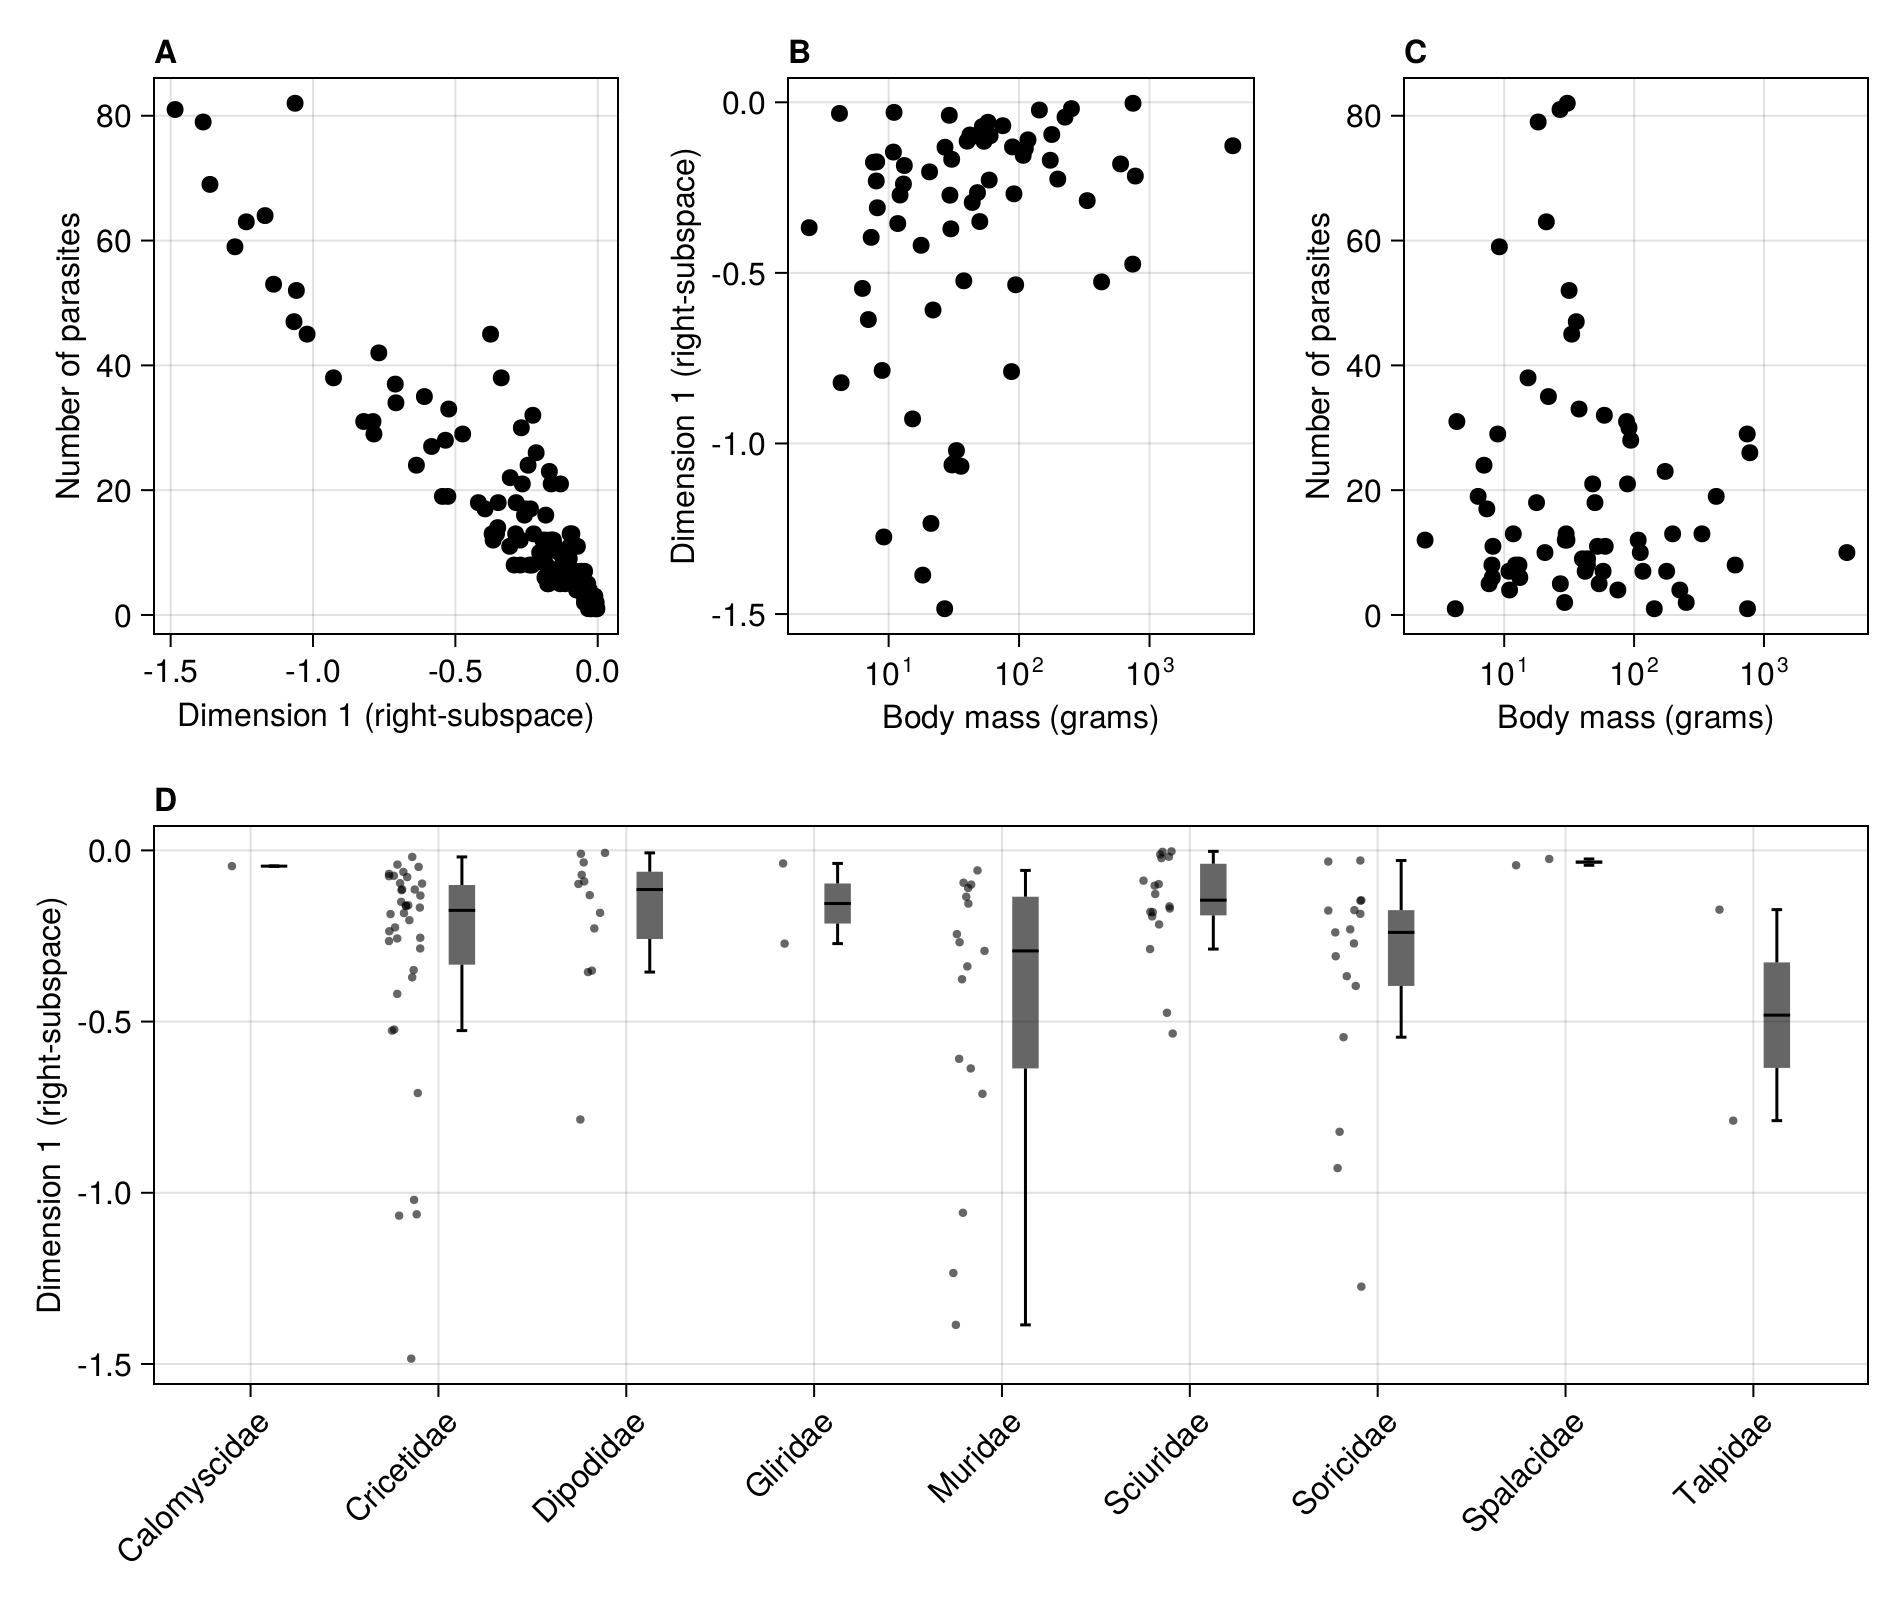

In [146]:
current_figure()